# Redes Neurais - Previsão de Série Temporal: Valor do Bitcoin

### Grupo 19
•⁠  ⁠Ana Sofia Lima (asosl)

•⁠  ⁠Arthur Marsaro (aam4)

•⁠  ⁠João Vitor Mergulhão (jvlm2)

•⁠  ⁠Pedro Monte (pvom)

•⁠  ⁠Victor Matheus (vmap)

| Hiperparâmetro específicos da LSTM | O que controla?                   | Valores típicos  |
| -------------- | --------------------------------- | ---------------- |
| `hidden_dim`   | Tamanho do vetor de estado oculto | 32, 64, 128, 256 |
| `layer_dim`    | Nº de camadas LSTM empilhadas     | 1, 2, às vezes 3 |
| `seq_length`   | Tamanho da janela de tempo usada para prever a próximo valor |  |

## Importa Bibliotecas e Prepara Device

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


## Carregamento e Visualização dos Dados

In [ ]:
df = pd.read_csv('data_bitcoin.csv')

In [ ]:
df.head()

date     open     high      low    close  number_of_trades
0  2017-08-17  4261.48  4485.39  4200.74  4285.08              3427
1  2017-08-18  4285.08  4371.52  3938.77  4108.37              5233
2  2017-08-19  4108.37  4184.69  3850.00  4139.98              2153
3  2017-08-20  4139.98  4211.08  4032.62  4086.29              2321
4  2017-08-21  4069.13  4119.62  3911.79  4016.00              3972

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2176 non-null   object 
 1   open              2176 non-null   float64
 2   high              2176 non-null   float64
 3   low               2176 non-null   float64
 4   close             2176 non-null   float64
 5   number_of_trades  2176 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 102.1+ KB


In [ ]:
df.describe()

open          high           low         close  \
count   2176.000000   2176.000000   2176.000000   2176.000000   
mean   20074.277578  20613.574283  19468.753051  20085.572486   
std    16058.230026  16490.568746  15560.344106  16055.913598   
min     3188.010000   3276.500000   2817.000000   3189.020000   
25%     7627.735000   7829.747500   7424.250000   7628.355000   
50%    11705.580000  11933.360000  11334.110000  11728.035000   
75%    29866.525000  30423.460000  29224.382500  29866.532500   
max    67525.820000  69000.000000  66222.400000  67525.830000   

       number_of_trades  
count      2.176000e+03  
mean       1.462627e+06  
std        2.057254e+06  
min        2.153000e+03  
25%        2.803172e+05  
50%        7.407820e+05  
75%        1.595982e+06  
max        1.522359e+07

In [ ]:
df_close = df['close']

In [ ]:
df_close.head()

0    4285.08
1    4108.37
2    4139.98
3    4086.29
4    4016.00
Name: close, dtype: float64

/tmp/ipython-input-10-746020422.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


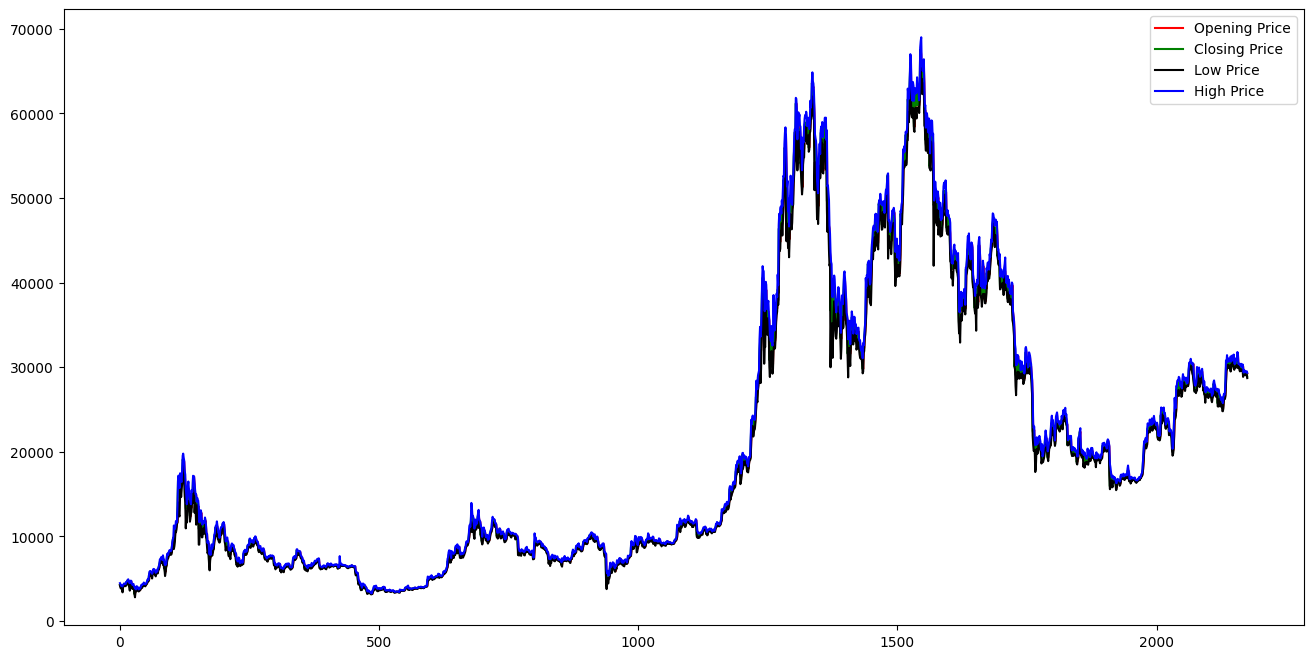

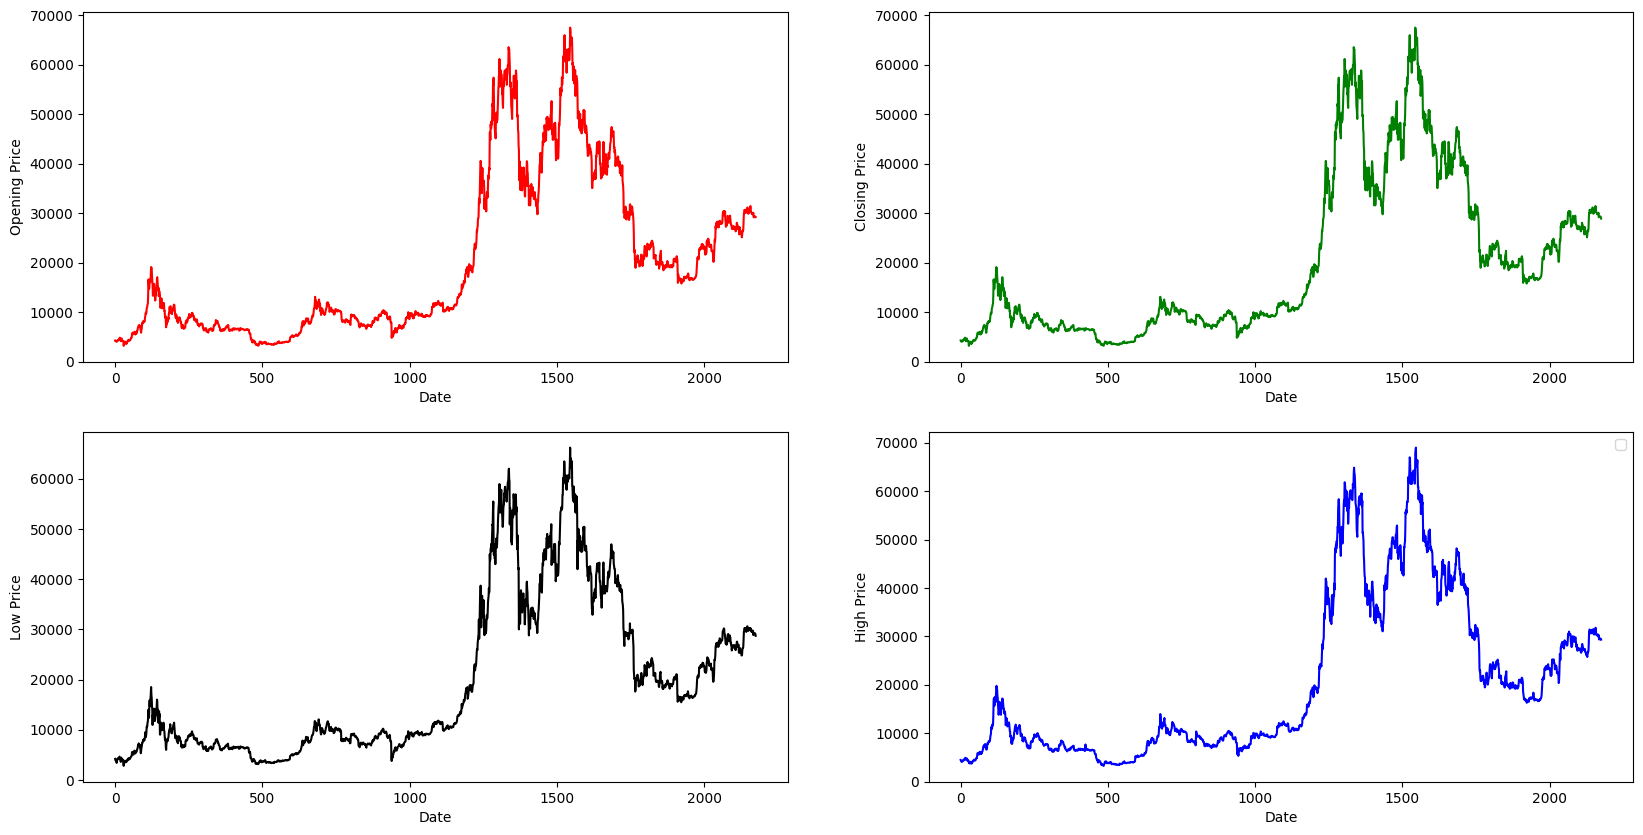

In [ ]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(df['open'], color='red', label = 'Opening Price')
plt.plot(df['close'], color='green', label = 'Closing Price')
plt.plot(df['low'], color='black', label = 'Low Price')
plt.plot(df['high'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(df['open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(df['close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(df['low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(df['high'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend(loc='best')

## Definição do Modelo e Treinamento

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

In [ ]:
def train_lstm(model, criterion, optimizer,
                          trainX, trainY, valX, valY,
                          num_epochs=100, patience=10, min_delta=1e-4):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(1, num_epochs+1):
        # ---- Treino ----
        model.train()
        optimizer.zero_grad()
        outputs, h0, c0 = model(trainX)
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()

        # ---- Validação ----
        model.eval()
        with torch.no_grad():
            val_outputs, _, _ = model(valX)
            val_loss = criterion(val_outputs, valY)

        # ---- Checa melhoria ----
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()  # guarda melhor modelo
        else:
            epochs_no_improve += 1

        # ---- Log ----
        if epoch % 10 == 0 or epoch == 1:
            print(f'Época {epoch}/{num_epochs} — '
                  f'Train Loss: {loss.item():.4f} — '
                  f'Val Loss: {val_loss.item():.4f} — '
                  f'Streak: {epochs_no_improve}/{patience}')

        # ---- Early Stopping ----
        if epochs_no_improve >= patience:
            print(f'--> Early stopping na época {epoch}. '
                  f'Melhor Val Loss: {best_val_loss:.4f}')
            break

    # Restaura pesos do melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model, best_val_loss


In [ ]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

## Função para Previsão Multi-Step

Cria um loop em que cada iteração usa a lstm para fazer a previsão um passo a frente. Na primeira iteração faz a previsão baseado em seq_length valores reais, na segunda usa o seq_length - 1 valores reais e o último valor previsto e assim por diante:
* Faz uma previsão 1 passo à frente
* Cria uma nova janela em que remove o primeiro valor a adiciona a nova previsão

In [ ]:
def forecast_n_steps(model, last_window, n_steps, input_dim):
    """
    model: modelo LSTM treinado
    last_window: tensor (1, seq_length, input_dim) -> última janela real
    n_steps: quantos passos você quer prever
    input_dim: número de features (1 se for univariado)
    """
    model.eval()
    preds = []
    window = last_window.clone()

    with torch.no_grad():
        h0, c0 = None, None

        for _ in range(n_steps):
            # Faz uma previsão 1 passo à frente
            y_pred, h0, c0 = model(window, h0, c0)

            # Guarda a previsão
            preds.append(y_pred.item())

            # Cria novo input com a previsão
            new_input = y_pred.view(1, 1, input_dim)

            # Remove o primeiro valor da janela e adiciona o novo
            window = torch.cat([window[:, 1:, :], new_input], dim=1)

            # Para estabilidade: detach dos hidden states
            h0 = h0.detach()
            c0 = c0.detach()

    return preds


## Funções Auxiliares

In [ ]:
import numpy as np

def inverse_transform_single_column(y_pred, scaler, num_feat, col_idx=0):
    """
    Desfaz a normalização de uma previsão de 1 coluna,
    usando o scaler que espera todas as features.

    Parâmetros:
    ----------
    y_pred : torch.Tensor ou np.ndarray
        Previsões normalizadas (shape: [N, 1] ou [N])
    scaler : sklearn MinMaxScaler
        O scaler já ajustado nos dados originais.
    num_feat : int
        Número total de features que o scaler espera.
    col_idx : int
        Índice da coluna onde a previsão estava (default: 0)

    Retorna:
    -------
    y_pred_denorm : np.ndarray
        Previsões desnormalizadas (shape: [N, 1])
    """

    # Se for tensor, converte pra numpy
    if hasattr(y_pred, 'cpu'):
        y_pred_np = y_pred.detach().cpu().numpy()
    else:
        y_pred_np = np.asarray(y_pred)

    # Garante forma correta
    y_pred_np = y_pred_np.squeeze()

    if y_pred_np.ndim == 0:
        y_pred_np = np.expand_dims(y_pred_np, 0)

    N = y_pred_np.shape[0]

    # Cria vetor fake com todas features
    y_pred_full = np.zeros((N, num_feat))
    y_pred_full[:, col_idx] = y_pred_np

    # Faz inverse transform
    y_pred_denorm_full = scaler.inverse_transform(y_pred_full)

    # Pega só a coluna de interesse
    y_pred_denorm = y_pred_denorm_full[:, col_idx].reshape(-1, 1)

    return y_pred_denorm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lstm_forecast(y_pred, X_raw, X_test, seq_length, label='Value'):
    """
    Plota previsões do modelo LSTM junto com os dados originais e a série combinada.

    Parâmetros:
    -----------
    y_pred_test : torch.Tensor
        Previsões do modelo em tensor.
    X_raw : numpy.ndarray
        Série original (não escalada).
    X_test : torch.Tensor
        Conjunto de teste em formato sequencial.
    seq_length : int
        Comprimento da janela de entrada usada na LSTM.
    label : str
        Nome do eixo Y (default: 'Value').
    """

    # Cria vetor de tempo para o trecho previsto
    original = X_raw[-len(y_pred):]
    time_pred = np.arange(len(X_raw) - len(y_pred), len(X_raw))

    # Reconstrói a série combinada
    look_back = seq_length
    train_end_idx = len(X_raw) - len(X_test) - look_back + 1

    real_part = X_raw[:train_end_idx].squeeze()
    forecast_part = y_pred.squeeze()

    combined = np.concatenate((real_part, forecast_part))
    time_combined = np.arange(len(combined))

    # Cria figura com subplots lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Subplot 1: Previsão local vs real
    axs[0].plot(time_pred, original, label='Original Data')
    axs[0].plot(time_pred, y_pred.squeeze(), label='Predicted Data', linestyle='--')
    axs[0].set_title('LSTM Predictions vs. Original Data')
    axs[0].set_xlabel('Time Step')
    axs[0].set_ylabel(label)
    axs[0].legend()

    # Subplot 2: Série combinada completa
    axs[1].plot(time_combined, combined, label='Combined Real + Predicted', linestyle='-')
    axs[1].axvline(x=len(real_part)-1, color='r', linestyle='--', label='Start of Prediction')
    axs[1].set_title('Full Series with Forecast Appended')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel(label)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return combined


## Separação dos dados

Separação dos dados:
* 70% dos dados foram separados para o treinamento, 10% para validação e 20% ficam reservados para o teste.

* X_all_train e X_all_test têm 5 features e são utilizados como conjuntos de treinamento e teste na abordagem 2.

* X_close_train e X_close_test apresentam apenas a feature `close` e são utilizados na abordagem 1.

Obs. é importante utilizar fit_transform apenas no conjunto de treinamento para evitar data leakege, caso o scaler seja treinado no conjunto inteiro. estatísticas de dados futuros iriam influenciar a normalização dos outros dados.

In [ ]:
# 1) Remove coluna date e extrai array numpy
df_raw = df.drop('date', axis=1)
X_raw  = df_raw.values
N      = len(X_raw)

# 2) Calcula tamanhos: 70% treino, 10% validação, 20% teste
train_size = int(N * 0.7)
val_size   = int(N * 0.1)
# test_size = N - train_size - val_size  # implícito

# 3) Faz o split temporal
X_train_raw = X_raw[:train_size]
X_val_raw   = X_raw[train_size:train_size + val_size]
X_test_raw  = X_raw[train_size + val_size:]

# 4) Normaliza **apenas** com scaler ajustado no treino
scaler      = MinMaxScaler(feature_range=(0, 1))
X_all_train = scaler.fit_transform(X_train_raw)
X_all_val   = scaler.transform(X_val_raw)
X_all_test  = scaler.transform(X_test_raw)

# 5) Converte para tensor e leva a GPU (se houver)
X_all_train = torch.tensor(X_all_train, dtype=torch.float32).to(device)
X_all_val   = torch.tensor(X_all_val,   dtype=torch.float32).to(device)
X_all_test  = torch.tensor(X_all_test,  dtype=torch.float32).to(device)

# 6) Extrai só a série 'close' (penúltima coluna) para cada split
X_close_train = X_all_train[:, -2].unsqueeze(1)  # shape (N_train, 1)
X_close_val   = X_all_val[:,   -2].unsqueeze(1)  # shape (N_val,   1)
X_close_test  = X_all_test[:,  -2].unsqueeze(1)  # shape (N_test,  1)

# 7) Verificação de shapes
print("train:", X_all_train.shape, "close:", X_close_train.shape)
print(" val:  ", X_all_val.shape,   "close:", X_close_val.shape)
print("test:  ", X_all_test.shape,  "close:", X_close_test.shape)

train: torch.Size([1523, 5]) close: torch.Size([1523, 1])
 val:   torch.Size([217, 5]) close: torch.Size([217, 1])
test:   torch.Size([436, 5]) close: torch.Size([436, 1])


## Abordagem 1: Apenas os valores de fechamento

In [ ]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.0894 — Val Loss: 0.2158 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0325 — Val Loss: 0.1004 — Streak: 3/20
Época 20/1000 — Train Loss: 0.0052 — Val Loss: 0.0061 — Streak: 3/20
Época 30/1000 — Train Loss: 0.0037 — Val Loss: 0.0044 — Streak: 4/20
Época 40/1000 — Train Loss: 0.0018 — Val Loss: 0.0018 — Streak: 14/20
--> Early stopping na época 46. Melhor Val Loss: 0.0017


(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0017, device='cuda:0'))

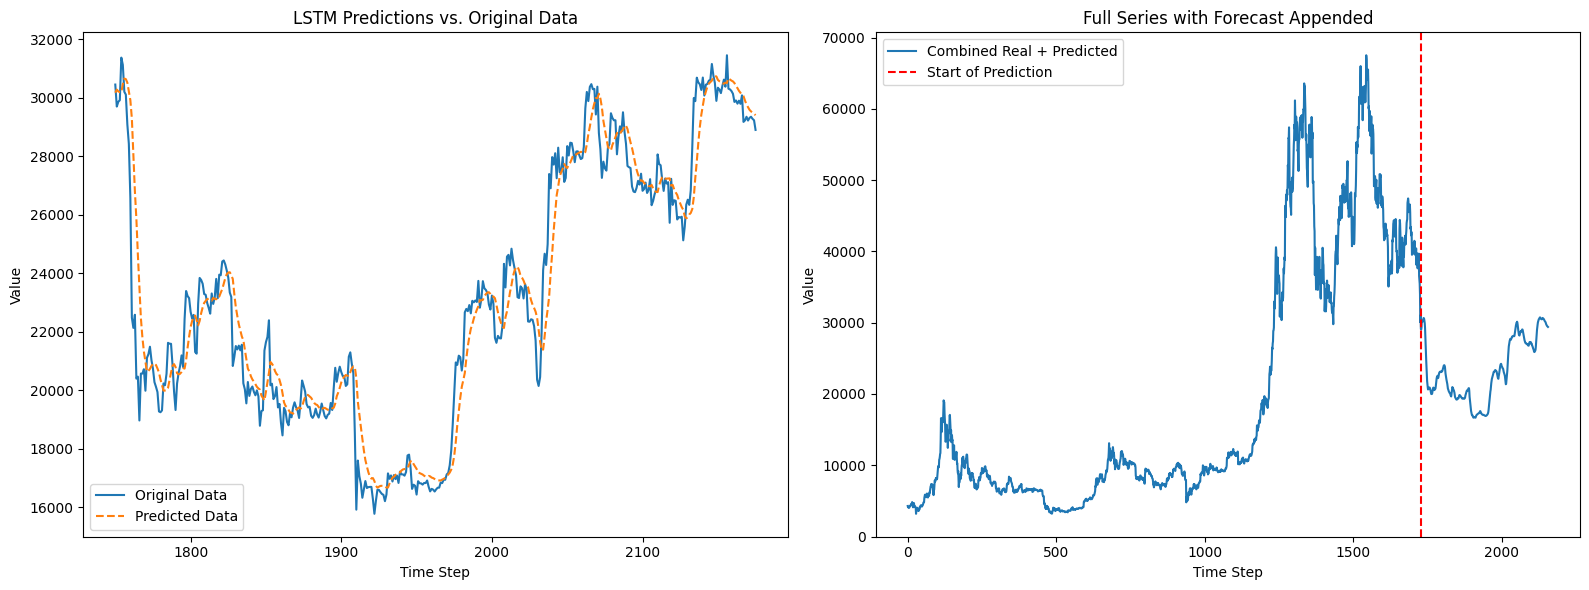

NMSE:   0.0689
R²:    0.9311
POCID: 43.76%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

### Previsão Multi-Step

In [ ]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

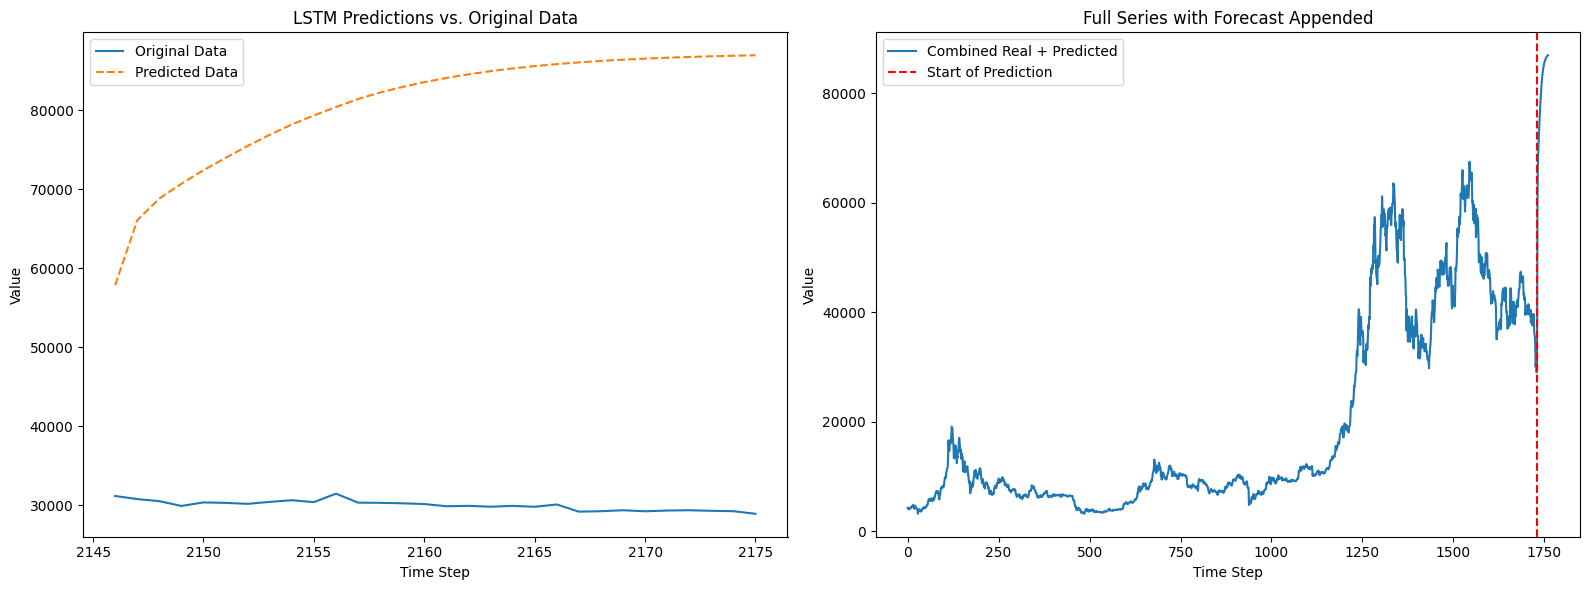

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       86842.69942559, 86913.52015127, 86973.76599933])

In [ ]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Abordagem 2: Usando Todas as Features

In [ ]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
num_feat = 5
patience = 20

In [ ]:
# cria sequências
X_train, _ = create_sequences(X_all_train, seq_length)
X_val, _ = create_sequences(X_all_val, seq_length)
X_test, _ = create_sequences(X_all_test, seq_length)

_, Y_train = create_sequences(X_close_train, seq_length)
_, Y_val = create_sequences(X_close_val, seq_length)
_, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)

torch.Size([1513, 10, 5])
torch.Size([207, 10, 5])
torch.Size([426, 10, 5])
torch.Size([1513, 1])


In [ ]:
model = LSTMModel(input_dim=num_feat, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1372 — Val Loss: 0.2052 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0167 — Val Loss: 0.0311 — Streak: 2/20
Época 20/1000 — Train Loss: 0.0019 — Val Loss: 0.0092 — Streak: 9/20
Época 30/1000 — Train Loss: 0.0012 — Val Loss: 0.0021 — Streak: 19/20
--> Early stopping na época 31. Melhor Val Loss: 0.0015


(LSTMModel(
   (lstm): LSTM(5, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0015, device='cuda:0'))

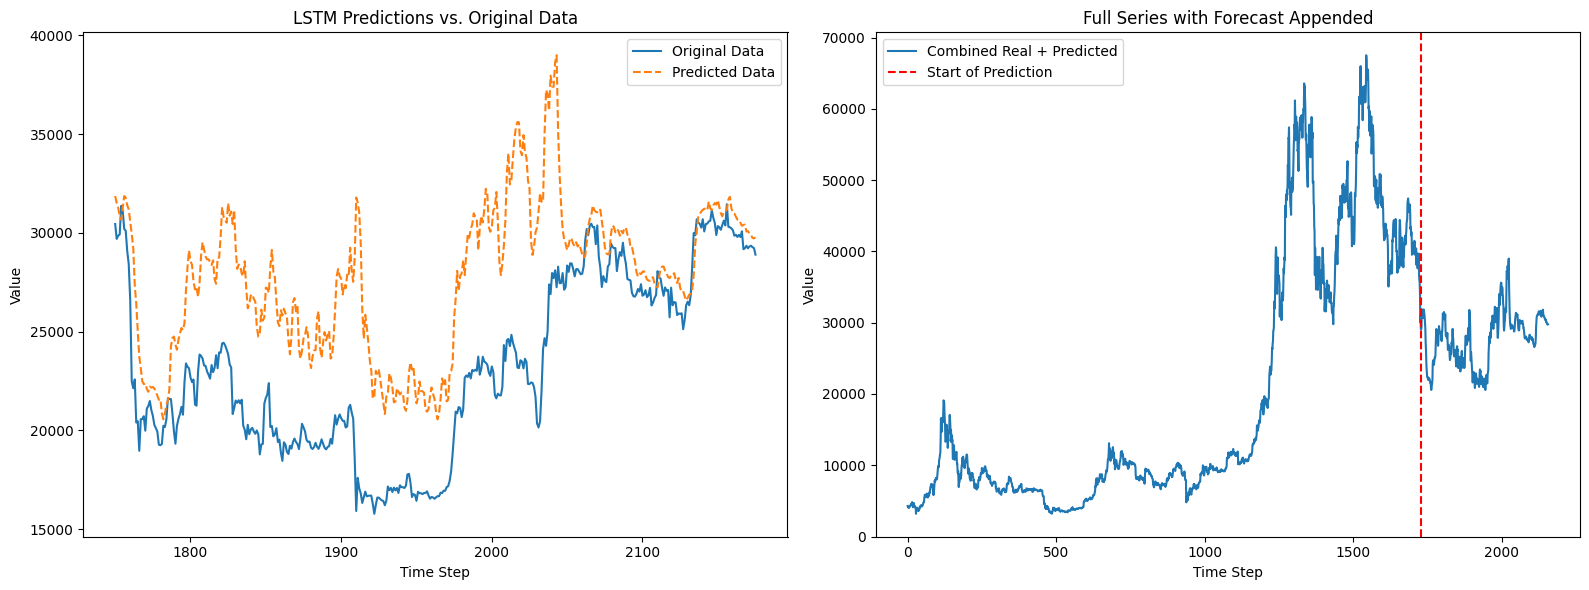

NMSE:   1.5504
R²:    -0.5504
POCID: 48.71%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

# Experimentos

Realizamos experimentos variando diversos hiperparâmetros e técnicas:
* Tamanho da Janela
* Dimensões
* Camadas
* Adição de Dropout
* Otimizador
* Utilização do Optuna

## Experimento - Mudança na Janela

Mudando a Janela para 50

In [ ]:
# Hiperparâmetros
seq_length = 50
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1473, 50, 1])
torch.Size([167, 50, 1])
torch.Size([386, 50, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1624 — Val Loss: 0.2224 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0723 — Val Loss: 0.2238 — Streak: 8/20
Época 20/1000 — Train Loss: 0.0145 — Val Loss: 0.0092 — Streak: 7/20
Época 30/1000 — Train Loss: 0.0022 — Val Loss: 0.0179 — Streak: 1/20
Época 40/1000 — Train Loss: 0.0016 — Val Loss: 0.0010 — Streak: 0/20
Época 50/1000 — Train Loss: 0.0011 — Val Loss: 0.0014 — Streak: 10/20
Época 60/1000 — Train Loss: 0.0005 — Val Loss: 0.0013 — Streak: 20/20
--> Early stopping na época 60. Melhor Val Loss: 0.0010


(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0010, device='cuda:0'))

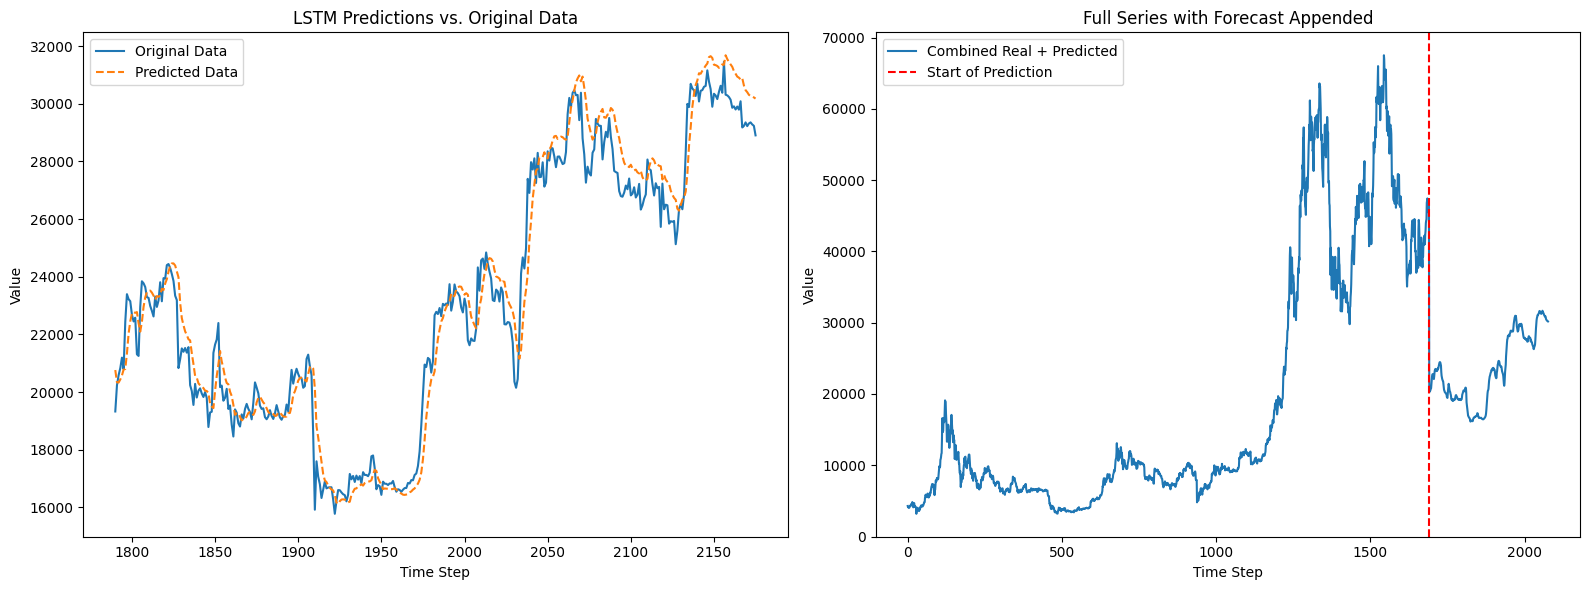

NMSE:   0.0455
R²:    0.9545
POCID: 46.49%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

## Experimento - Mudança na Janela

Mudança da Janela para 5

In [ ]:
# Hiperparâmetros
seq_length = 5
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1518, 5, 1])
torch.Size([212, 5, 1])
torch.Size([431, 5, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.0784 — Val Loss: 0.1866 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0075 — Val Loss: 0.0284 — Streak: 4/20
Época 20/1000 — Train Loss: 0.0016 — Val Loss: 0.0045 — Streak: 3/20
Época 30/1000 — Train Loss: 0.0023 — Val Loss: 0.0042 — Streak: 13/20
Época 40/1000 — Train Loss: 0.0007 — Val Loss: 0.0024 — Streak: 8/20
Época 50/1000 — Train Loss: 0.0006 — Val Loss: 0.0023 — Streak: 8/20
Época 60/1000 — Train Loss: 0.0005 — Val Loss: 0.0012 — Streak: 1/20
Época 70/1000 — Train Loss: 0.0005 — Val Loss: 0.0013 — Streak: 11/20
--> Early stopping na época 79. Melhor Val Loss: 0.0012


(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0012, device='cuda:0'))

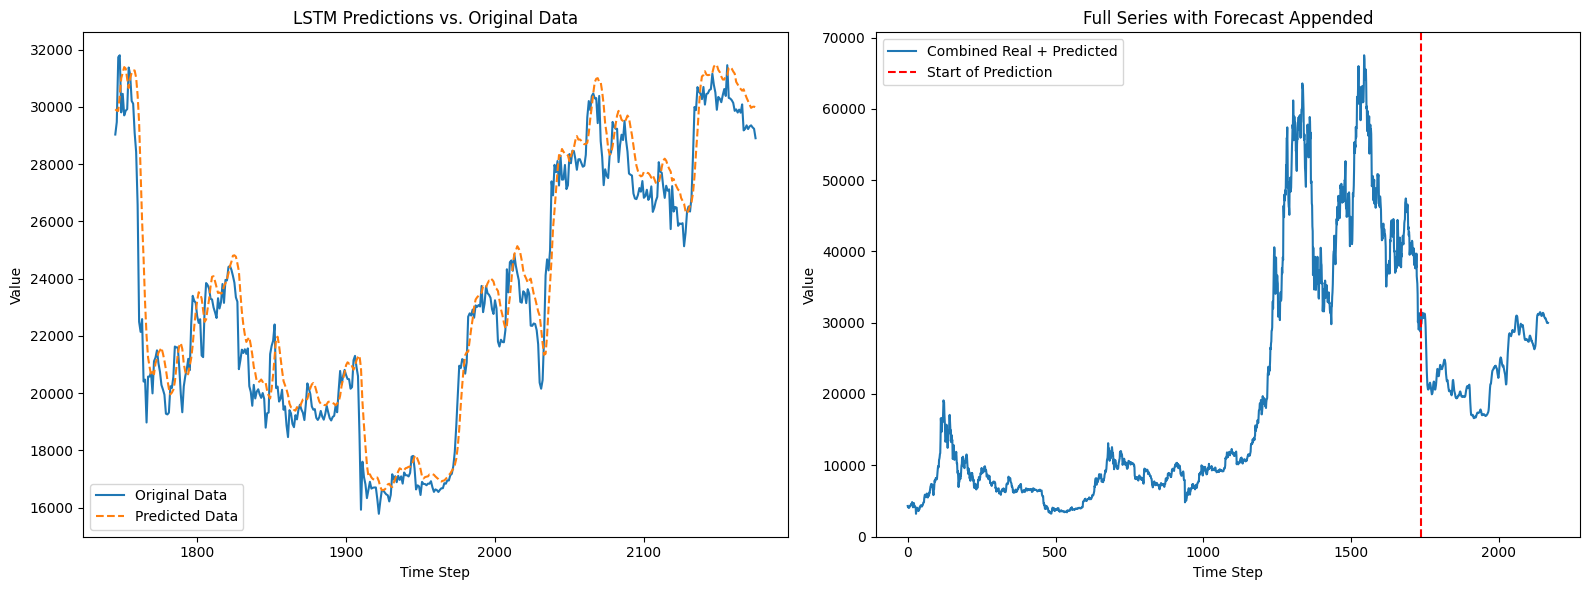

NMSE:   0.0652
R²:    0.9348
POCID: 43.49%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

## Experimento - Mudança no hidden_dim

Mudança de hidden_dim para 50

In [ ]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 50
layer_dim = 1
learning_rate = 0.01
patience = 20

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.0995 — Val Loss: 0.2729 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0115 — Val Loss: 0.0362 — Streak: 1/20
Época 20/1000 — Train Loss: 0.0025 — Val Loss: 0.0082 — Streak: 1/20
Época 30/1000 — Train Loss: 0.0014 — Val Loss: 0.0018 — Streak: 5/20
Época 40/1000 — Train Loss: 0.0009 — Val Loss: 0.0018 — Streak: 15/20
--> Early stopping na época 45. Melhor Val Loss: 0.0014


(LSTMModel(
   (lstm): LSTM(1, 50, batch_first=True)
   (fc): Linear(in_features=50, out_features=1, bias=True)
 ),
 tensor(0.0014, device='cuda:0'))

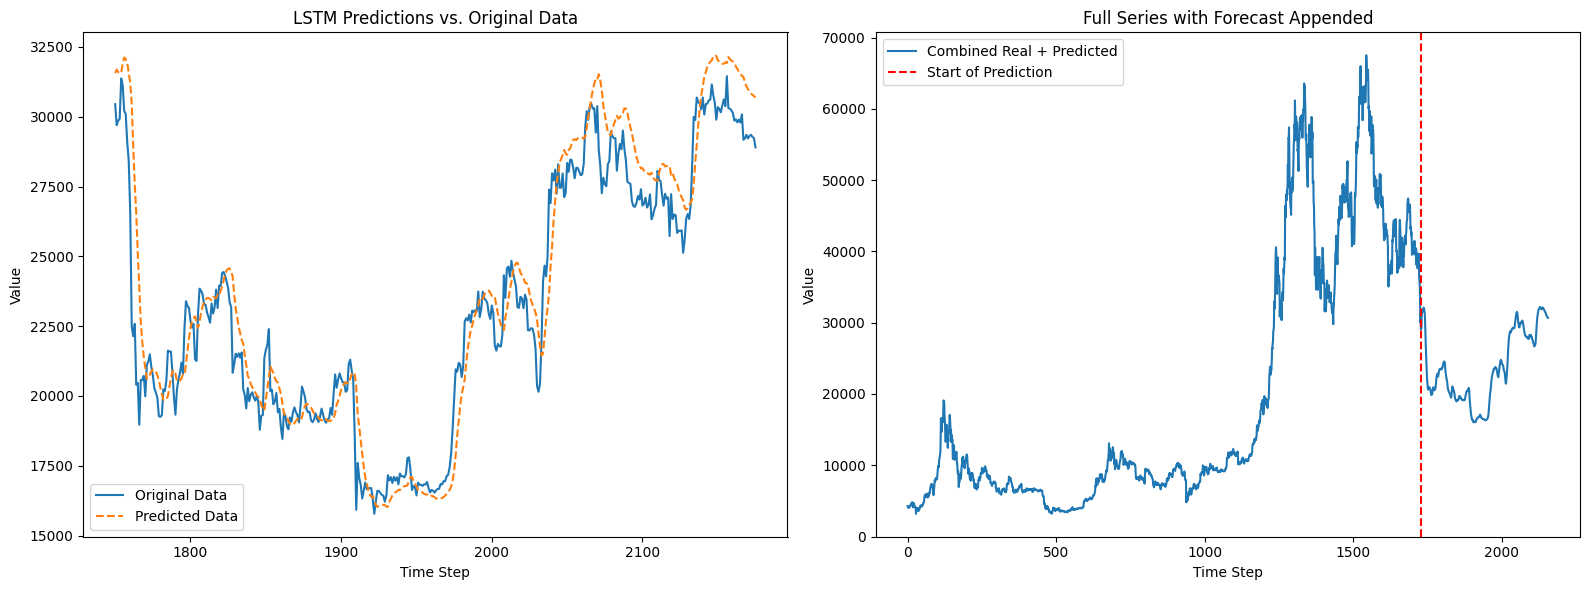

NMSE:   0.1013
R²:    0.8987
POCID: 44.24%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

## Experimento - Mudança no hidden_dim

Mudança de hidden_dim para 200

In [ ]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 200
layer_dim = 1
learning_rate = 0.01
patience = 20

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1307 — Val Loss: 0.1386 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0030 — Val Loss: 0.1048 — Streak: 6/20
Época 20/1000 — Train Loss: 0.0128 — Val Loss: 0.0053 — Streak: 1/20
Época 30/1000 — Train Loss: 0.0018 — Val Loss: 0.0079 — Streak: 9/20
Época 40/1000 — Train Loss: 0.0010 — Val Loss: 0.0013 — Streak: 19/20
--> Early stopping na época 41. Melhor Val Loss: 0.0012


(LSTMModel(
   (lstm): LSTM(1, 200, batch_first=True)
   (fc): Linear(in_features=200, out_features=1, bias=True)
 ),
 tensor(0.0012, device='cuda:0'))

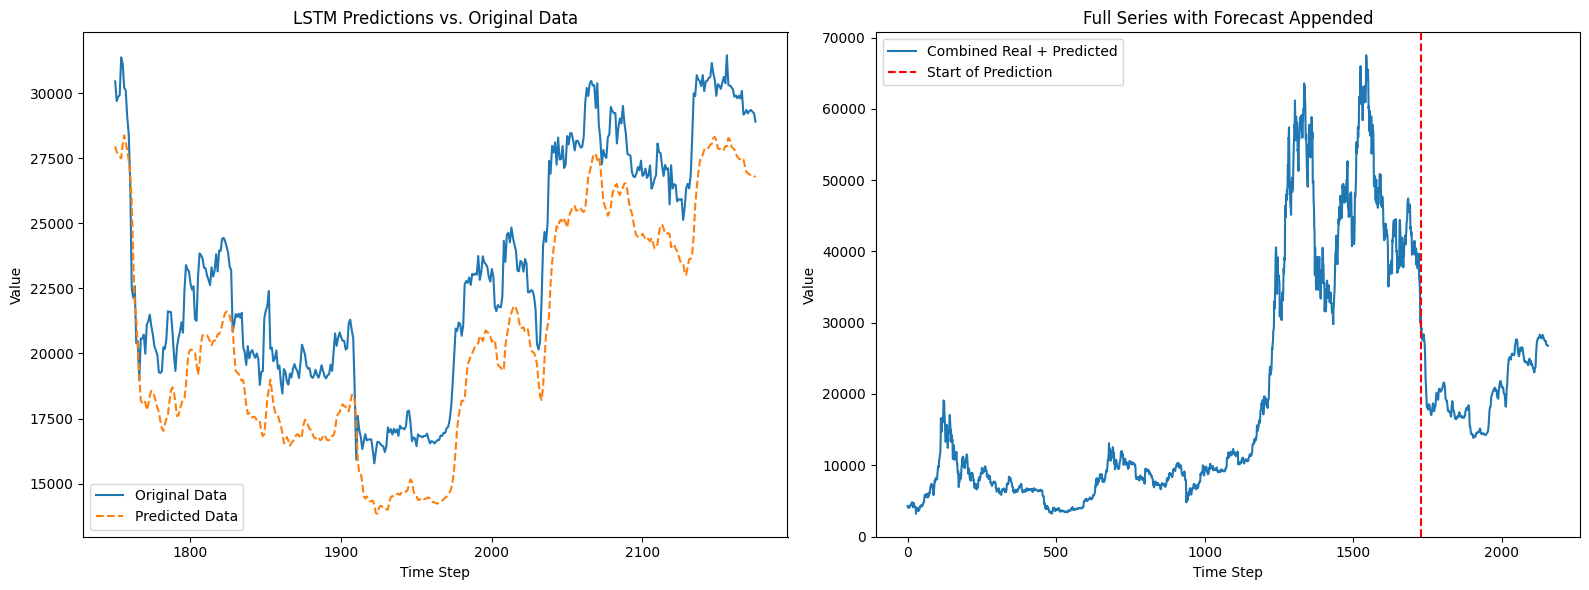

NMSE:   0.3533
R²:    0.6467
POCID: 48.00%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

## Experimento - Mudança no layer_dim

Mudança de hidden_dim para 3

In [ ]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 3
learning_rate = 0.01
patience = 20

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.0783 — Val Loss: 0.0432 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0503 — Val Loss: 0.0983 — Streak: 1/20
Época 20/1000 — Train Loss: 0.0077 — Val Loss: 0.0202 — Streak: 7/20
Época 30/1000 — Train Loss: 0.0043 — Val Loss: 0.0184 — Streak: 17/20
--> Early stopping na época 33. Melhor Val Loss: 0.0084


(LSTMModel(
   (lstm): LSTM(1, 100, num_layers=3, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0084, device='cuda:0'))

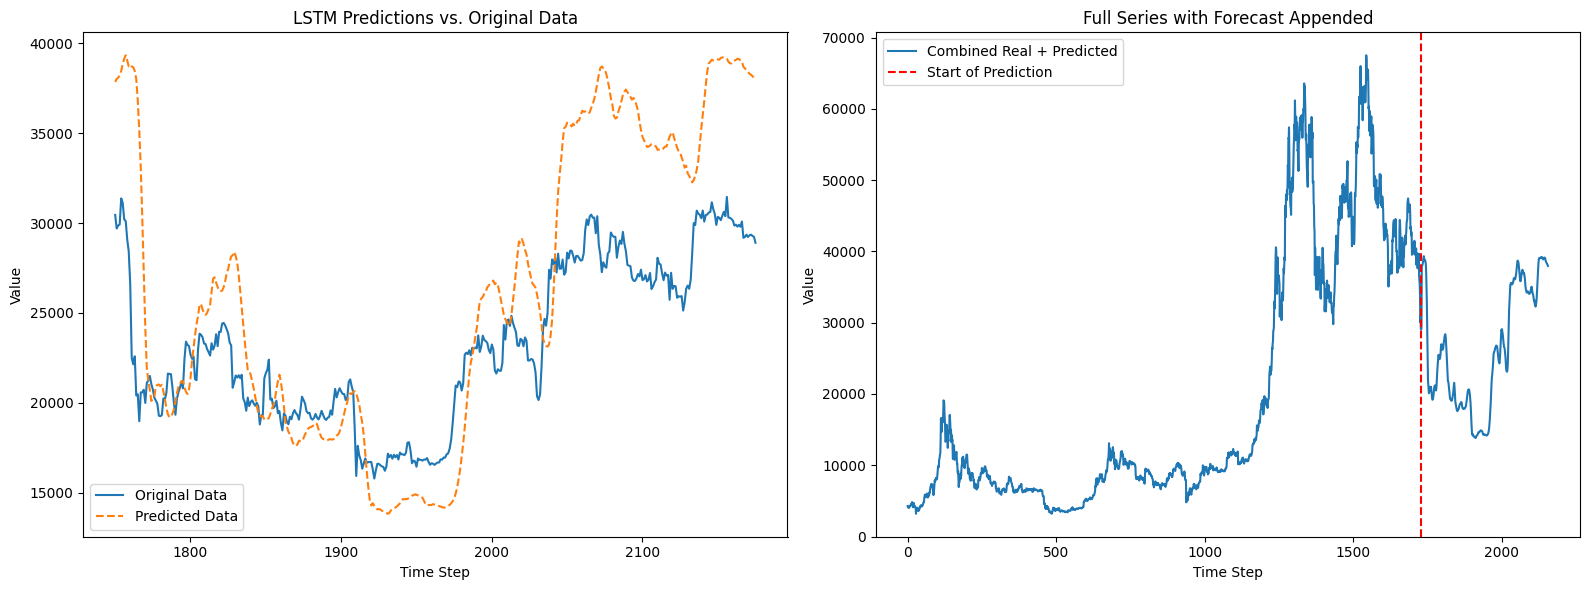

NMSE:   1.5470
R²:    -0.5470
POCID: 50.12%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

## Experimento - Mudança no otimizador

Mudança para SGD

In [ ]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.0912 — Val Loss: 0.4375 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0813 — Val Loss: 0.3938 — Streak: 0/20
Época 20/1000 — Train Loss: 0.0747 — Val Loss: 0.3580 — Streak: 0/20
Época 30/1000 — Train Loss: 0.0707 — Val Loss: 0.3316 — Streak: 0/20
Época 40/1000 — Train Loss: 0.0683 — Val Loss: 0.3119 — Streak: 0/20
Época 50/1000 — Train Loss: 0.0668 — Val Loss: 0.2971 — Streak: 0/20
Época 60/1000 — Train Loss: 0.0658 — Val Loss: 0.2858 — Streak: 0/20
Época 70/1000 — Train Loss: 0.0651 — Val Loss: 0.2770 — Streak: 0/20
Época 80/1000 — Train Loss: 0.0646 — Val Loss: 0.2702 — Streak: 0/20
Época 90/1000 — Train Loss: 0.0642 — Val Loss: 0.2649 — Streak: 0/20
Época 100/1000 — Train Loss: 0.0639 — Val Loss: 0.2605 — Streak: 0/20
Época 110/1000 — Train Loss: 0.0635 — Val Loss: 0.2570 — Streak: 0/20
Época 120/1000 — Train Loss: 0.0632 — Val Loss: 0.2541 — Streak: 0/20
Época 130/1000 — Train Loss: 0.0629 — Val Loss: 0.2516 — Streak: 0/20
Época 140/1000 — Train Loss: 0.

(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.1444, device='cuda:0'))

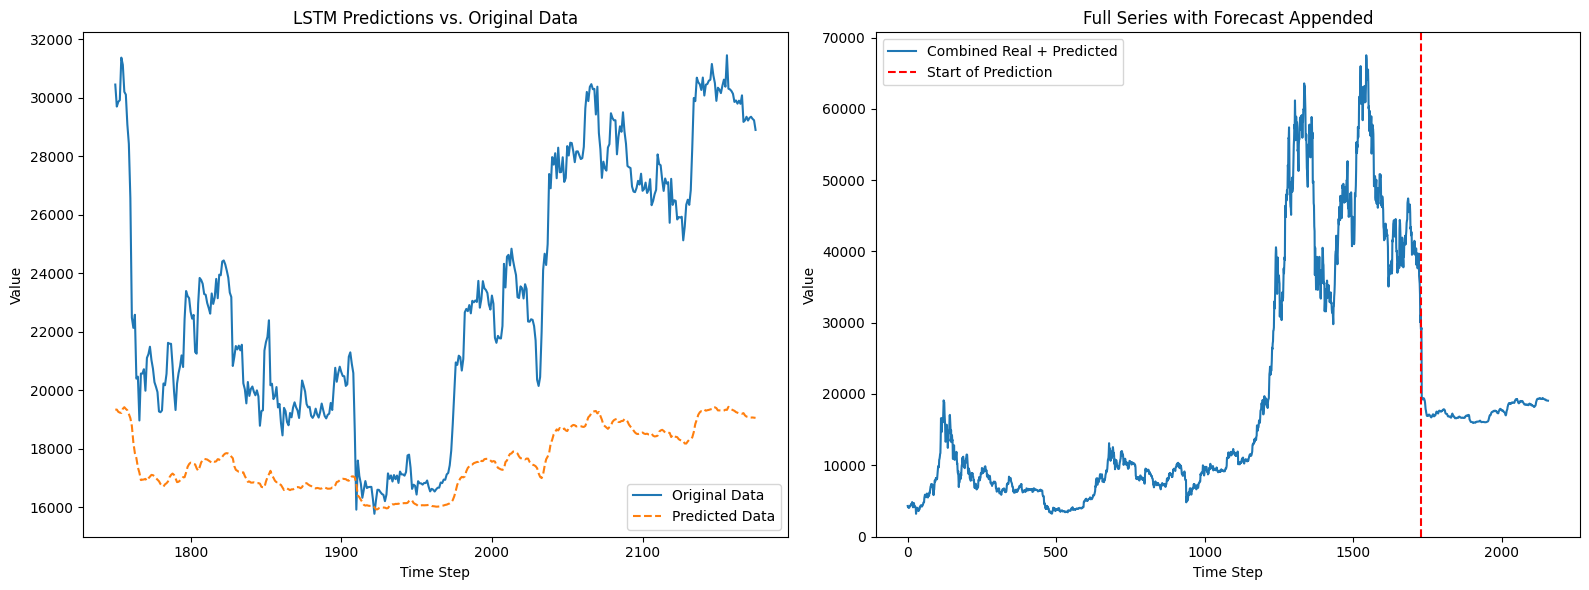

NMSE:   2.1537
R²:    -1.1537
POCID: 45.88%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

## Experimento - Dropout = 0.2

In [ ]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20
dropout = 0.2

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1, dropout=dropout)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1498 — Val Loss: 0.3155 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0223 — Val Loss: 0.0044 — Streak: 0/20
Época 20/1000 — Train Loss: 0.0016 — Val Loss: 0.0067 — Streak: 8/20
Época 30/1000 — Train Loss: 0.0008 — Val Loss: 0.0020 — Streak: 5/20
Época 40/1000 — Train Loss: 0.0005 — Val Loss: 0.0017 — Streak: 1/20
Época 50/1000 — Train Loss: 0.0005 — Val Loss: 0.0012 — Streak: 11/20
--> Early stopping na época 59. Melhor Val Loss: 0.0011


(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0011, device='cuda:0'))

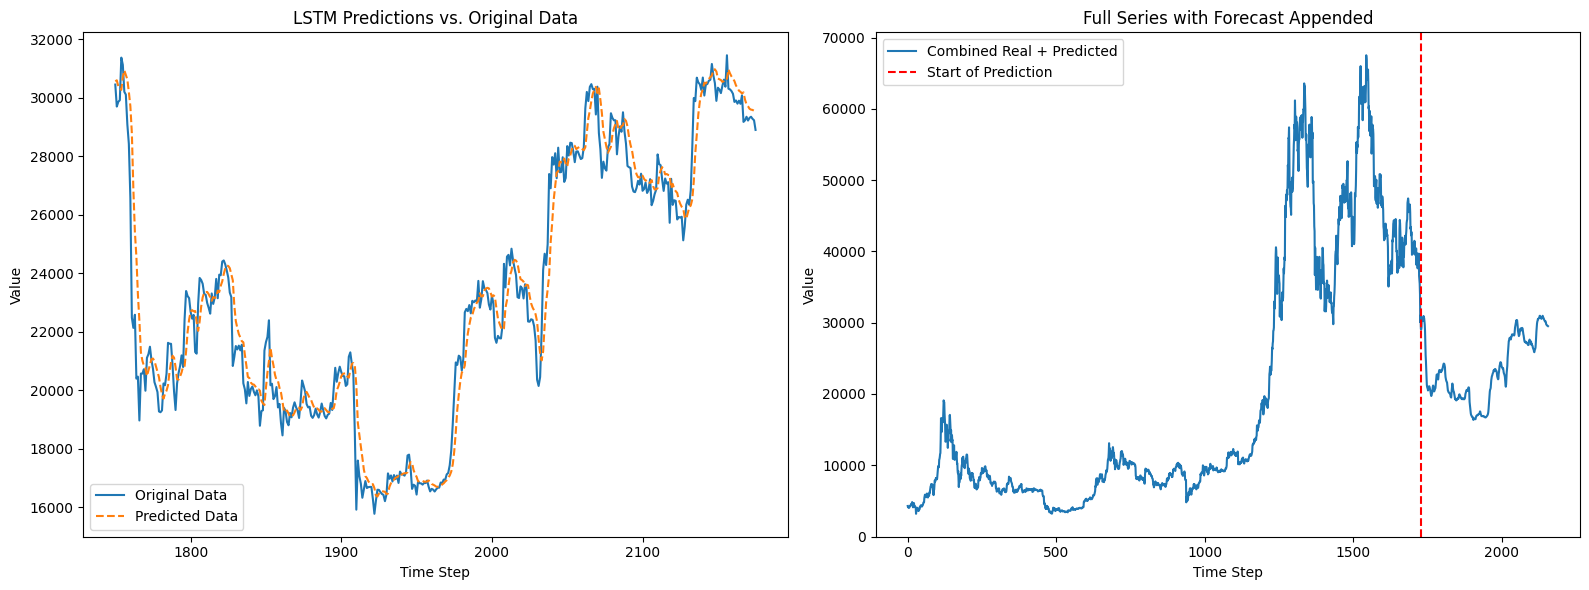

NMSE:   0.0479
R²:    0.9521
POCID: 46.35%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

### Previsão Multi-Step

In [ ]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

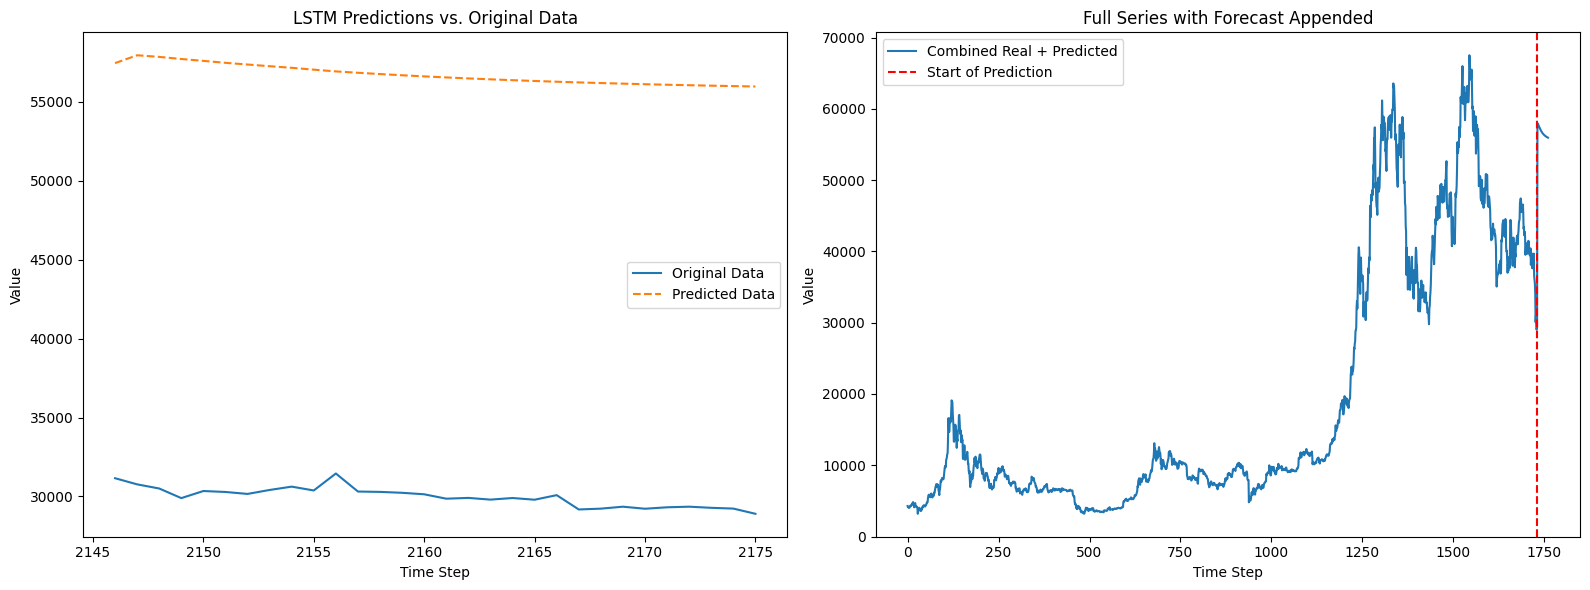

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       56014.98751737, 55988.10040511, 55962.99496896])

In [ ]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Dropout = 0.5

In [ ]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20
dropout = 0.5

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1, dropout=dropout)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1135 — Val Loss: 0.2630 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0382 — Val Loss: 0.0019 — Streak: 0/20
Época 20/1000 — Train Loss: 0.0019 — Val Loss: 0.0044 — Streak: 10/20
Época 30/1000 — Train Loss: 0.0026 — Val Loss: 0.0054 — Streak: 20/20
--> Early stopping na época 30. Melhor Val Loss: 0.0019


(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0019, device='cuda:0'))

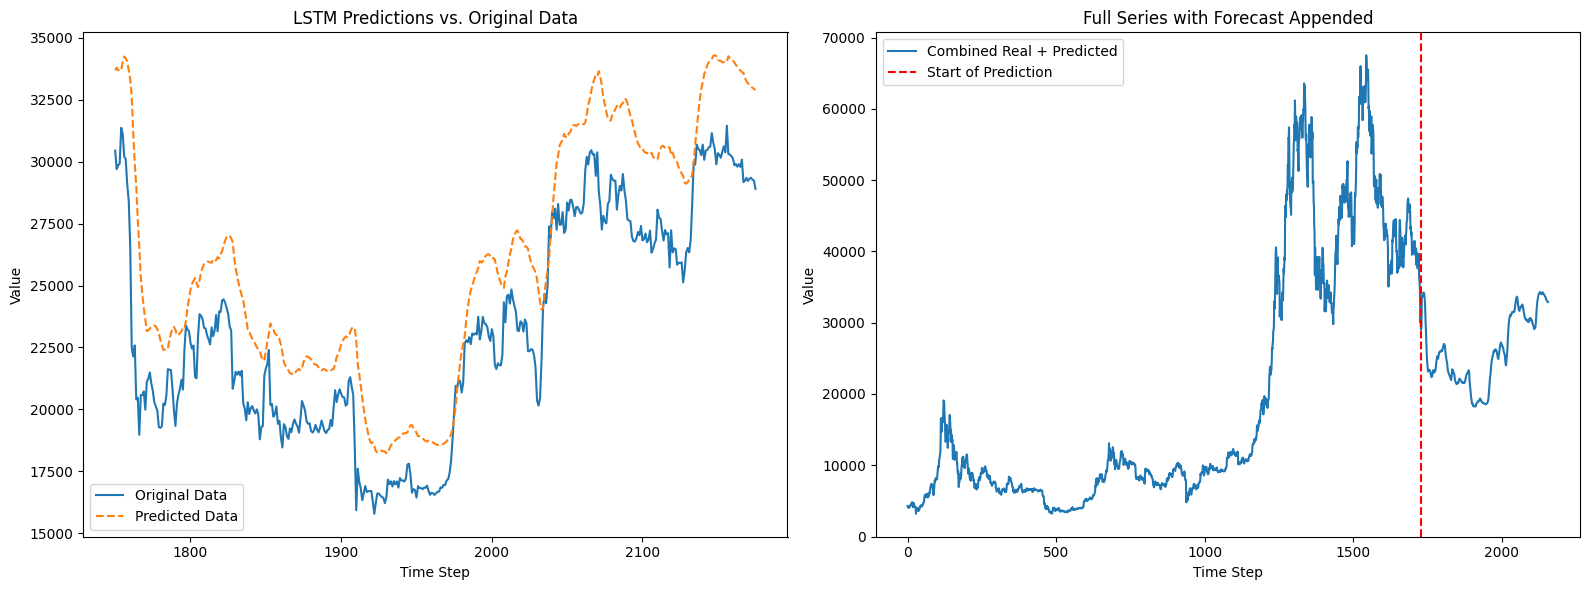

NMSE:   0.4919
R²:    0.5081
POCID: 45.88%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

### Previsão Multi-Step

In [ ]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

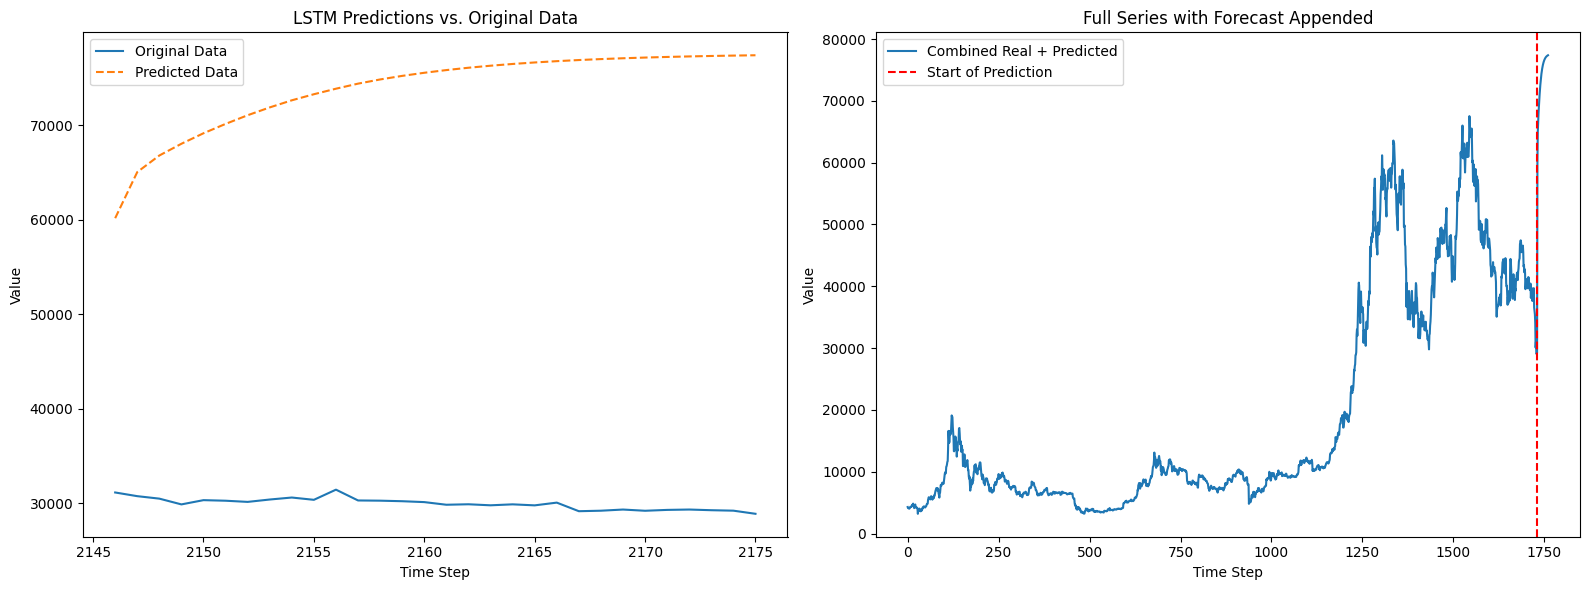

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       77297.32825447, 77338.02245677, 77372.95050729])

In [ ]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Clip-margin = 1

In [ ]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20
clip_margin = 1

In [ ]:
def train_lstm_clip_margin(model, criterion, optimizer,
                          trainX, trainY, valX, valY,
                          num_epochs=100, patience=10, min_delta=1e-4):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(1, num_epochs+1):
        # ---- Treino ----
        model.train()
        optimizer.zero_grad()
        outputs, h0, c0 = model(trainX)
        loss = criterion(outputs, trainY)
        loss.backward()


        parameters = [p for p in model.parameters() if p.grad is not None]
        total_norm = torch.norm(torch.stack([p.grad.detach().norm(2) for p in parameters]), 2).item()
        print(f"Grad norm before clip: {total_norm:.4f}")

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_margin)

        total_norm_after = torch.norm(torch.stack([p.grad.detach().norm(2) for p in parameters]), 2).item()
        print(f"Grad norm after clip: {total_norm_after:.4f}")
        optimizer.step()

        # ---- Validação ----
        model.eval()
        with torch.no_grad():
            val_outputs, _, _ = model(valX)
            val_loss = criterion(val_outputs, valY)

        # ---- Checa melhoria ----
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()  # guarda melhor modelo
        else:
            epochs_no_improve += 1

        # ---- Log ----
        if epoch % 10 == 0 or epoch == 1:
            print(f'Época {epoch}/{num_epochs} — '
                  f'Train Loss: {loss.item():.4f} — '
                  f'Val Loss: {val_loss.item():.4f} — '
                  f'Streak: {epochs_no_improve}/{patience}')

        # ---- Early Stopping ----
        if epochs_no_improve >= patience:
            print(f'--> Early stopping na época {epoch}. '
                  f'Melhor Val Loss: {best_val_loss:.4f}')
            break

    # Restaura pesos do melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model


In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm_clip_margin(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Grad norm before clip: 0.5564
Grad norm after clip: 0.5564
Época 1/1000 — Train Loss: 0.1192 — Val Loss: 0.2063 — Streak: 0/20
Grad norm before clip: 0.0754
Grad norm after clip: 0.0754
Grad norm before clip: 0.8428
Grad norm after clip: 0.8428
Grad norm before clip: 0.0761
Grad norm after clip: 0.0761
Grad norm before clip: 0.2322
Grad norm after clip: 0.2322
Grad norm before clip: 0.2849
Grad norm after clip: 0.2849
Grad norm before clip: 0.2814
Grad norm after clip: 0.2814
Grad norm before clip: 0.2432
Grad norm after clip: 0.2432
Grad norm before clip: 0.1738
Grad norm after clip: 0.1738
Grad norm before clip: 0.0841
Grad norm after clip: 0.0841
Época 10/1000 — Train Loss: 0.0176 — Val Loss: 0.0057 — Streak: 0/20
Grad norm before clip: 0.3866
Grad norm after clip: 0.3866
Grad norm before clip: 0.5039
Grad norm after clip: 0.5039
Grad norm before clip: 0.1445
Grad norm after clip: 0.1445
Grad norm before clip: 0.0967
Grad norm after clip: 0.0967
Grad norm before clip: 0.1850
Grad no

LSTMModel(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

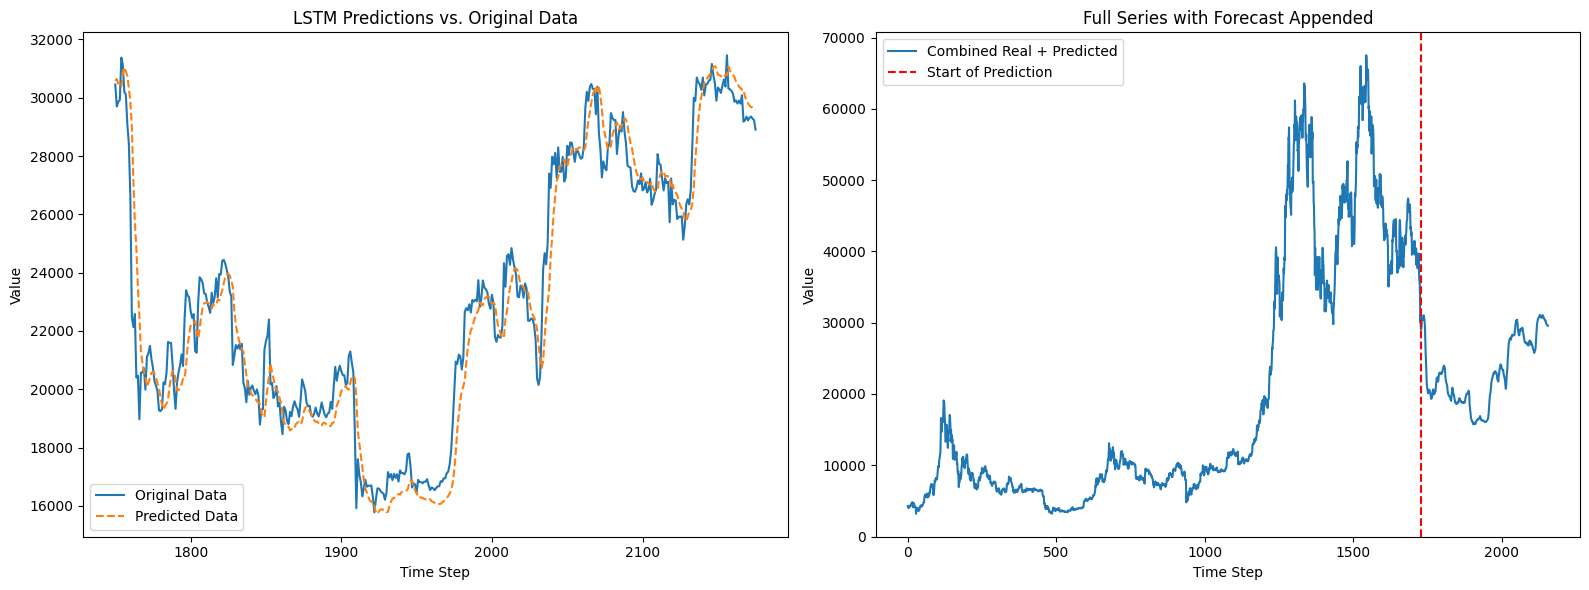

NMSE:   0.0600
R²:    0.9400
POCID: 46.82%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

### Previsão Multi-Step

In [ ]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

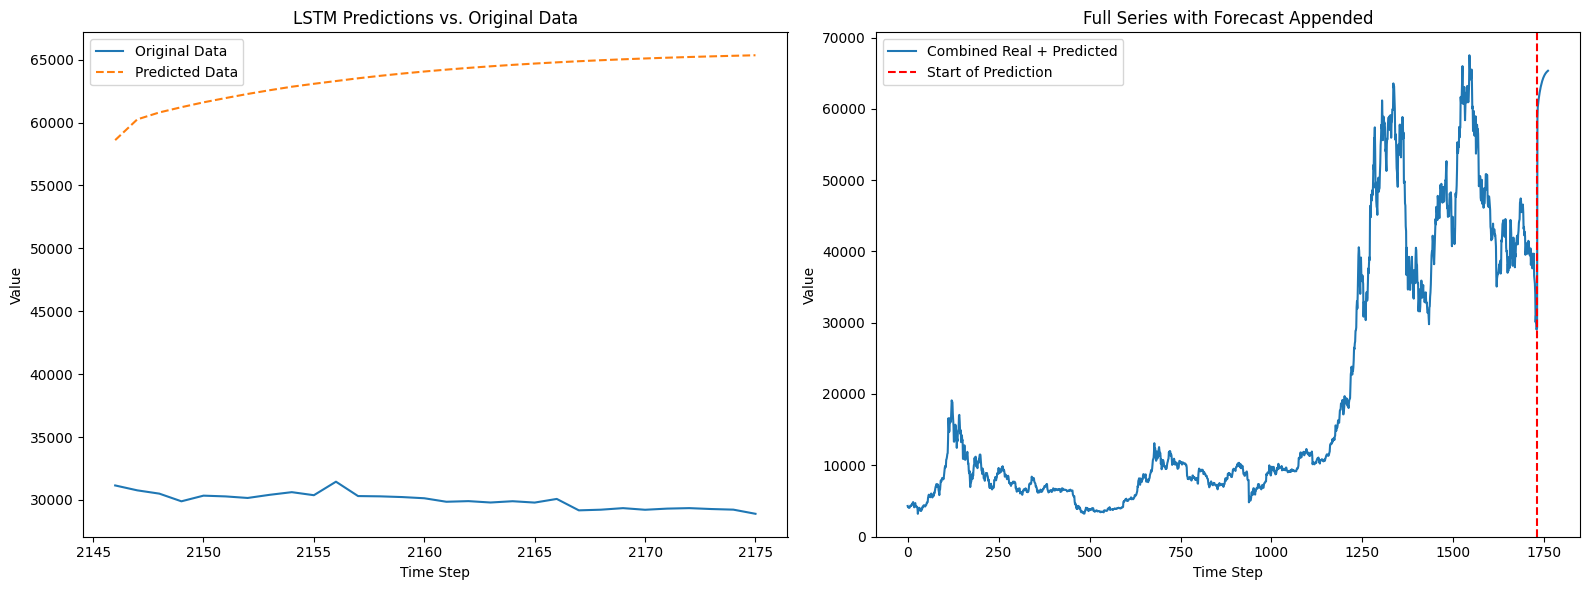

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       65262.75038994, 65308.81481601, 65350.78318668])

In [ ]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Clip-margin = 0.5

In [ ]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20
clip_margin = 0.5

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm_clip_margin(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Grad norm before clip: 0.2726
Grad norm after clip: 0.2726
Época 1/1000 — Train Loss: 0.0731 — Val Loss: 0.1027 — Streak: 0/20
Grad norm before clip: 0.3197
Grad norm after clip: 0.3197
Grad norm before clip: 0.0728
Grad norm after clip: 0.0728
Grad norm before clip: 0.1095
Grad norm after clip: 0.1095
Grad norm before clip: 0.1336
Grad norm after clip: 0.1336
Grad norm before clip: 0.0914
Grad norm after clip: 0.0914
Grad norm before clip: 1.0163
Grad norm after clip: 0.5000
Grad norm before clip: 0.0277
Grad norm after clip: 0.0277
Grad norm before clip: 0.4292
Grad norm after clip: 0.4292
Grad norm before clip: 0.3269
Grad norm after clip: 0.3269
Época 10/1000 — Train Loss: 0.0125 — Val Loss: 0.0092 — Streak: 3/20
Grad norm before clip: 0.0875
Grad norm after clip: 0.0875
Grad norm before clip: 0.2175
Grad norm after clip: 0.2175
Grad norm before clip: 0.3581
Grad norm after clip: 0.3581
Grad norm before clip: 0.2057
Grad norm after clip: 0.2057
Grad norm before clip: 0.0419
Grad no

LSTMModel(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

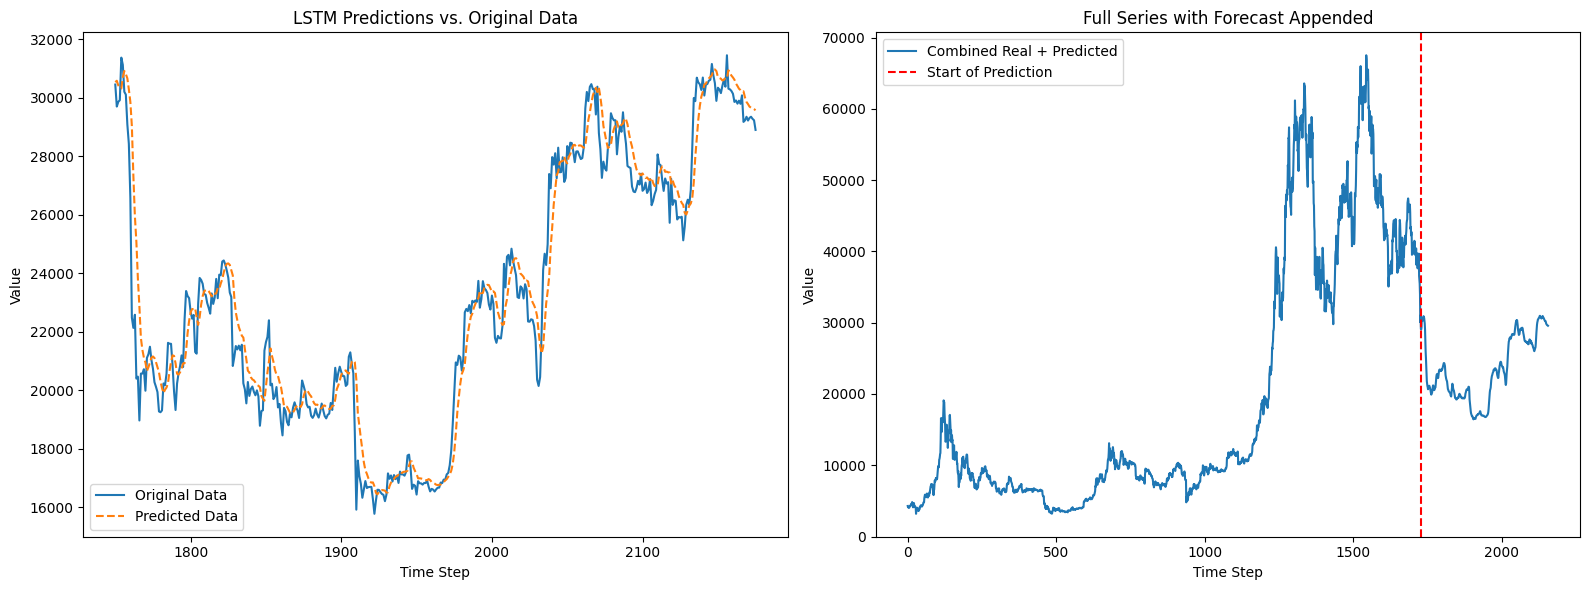

NMSE:   0.0551
R²:    0.9449
POCID: 46.59%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

### Previsão Multi-Step

In [ ]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

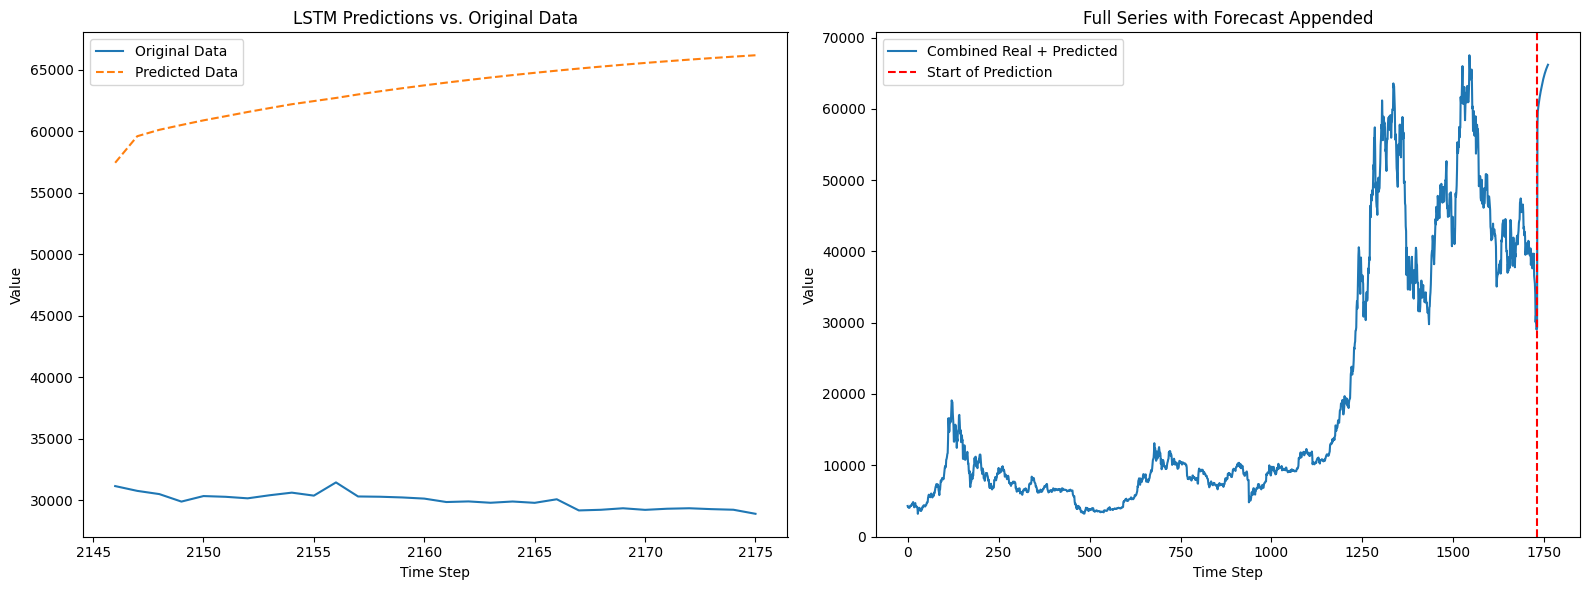

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       65962.09605766, 66080.50733198, 66192.94369246])

In [ ]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Clip-margin = 0.2

In [ ]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20
clip_margin = 3

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm_clip_margin(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Grad norm before clip: 0.5961
Grad norm after clip: 0.5961
Época 1/1000 — Train Loss: 0.1259 — Val Loss: 0.2647 — Streak: 0/20
Grad norm before clip: 0.1392
Grad norm after clip: 0.1392
Grad norm before clip: 0.8330
Grad norm after clip: 0.8330
Grad norm before clip: 0.0916
Grad norm after clip: 0.0916
Grad norm before clip: 0.1692
Grad norm after clip: 0.1692
Grad norm before clip: 0.2418
Grad norm after clip: 0.2418
Grad norm before clip: 0.2473
Grad norm after clip: 0.2473
Grad norm before clip: 0.2061
Grad norm after clip: 0.2061
Grad norm before clip: 0.1173
Grad norm after clip: 0.1173
Grad norm before clip: 0.1783
Grad norm after clip: 0.1783
Época 10/1000 — Train Loss: 0.0161 — Val Loss: 0.0370 — Streak: 1/20
Grad norm before clip: 0.6564
Grad norm after clip: 0.6564
Grad norm before clip: 0.2237
Grad norm after clip: 0.2237
Grad norm before clip: 0.0955
Grad norm after clip: 0.0955
Grad norm before clip: 0.2179
Grad norm after clip: 0.2179
Grad norm before clip: 0.2678
Grad no

LSTMModel(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

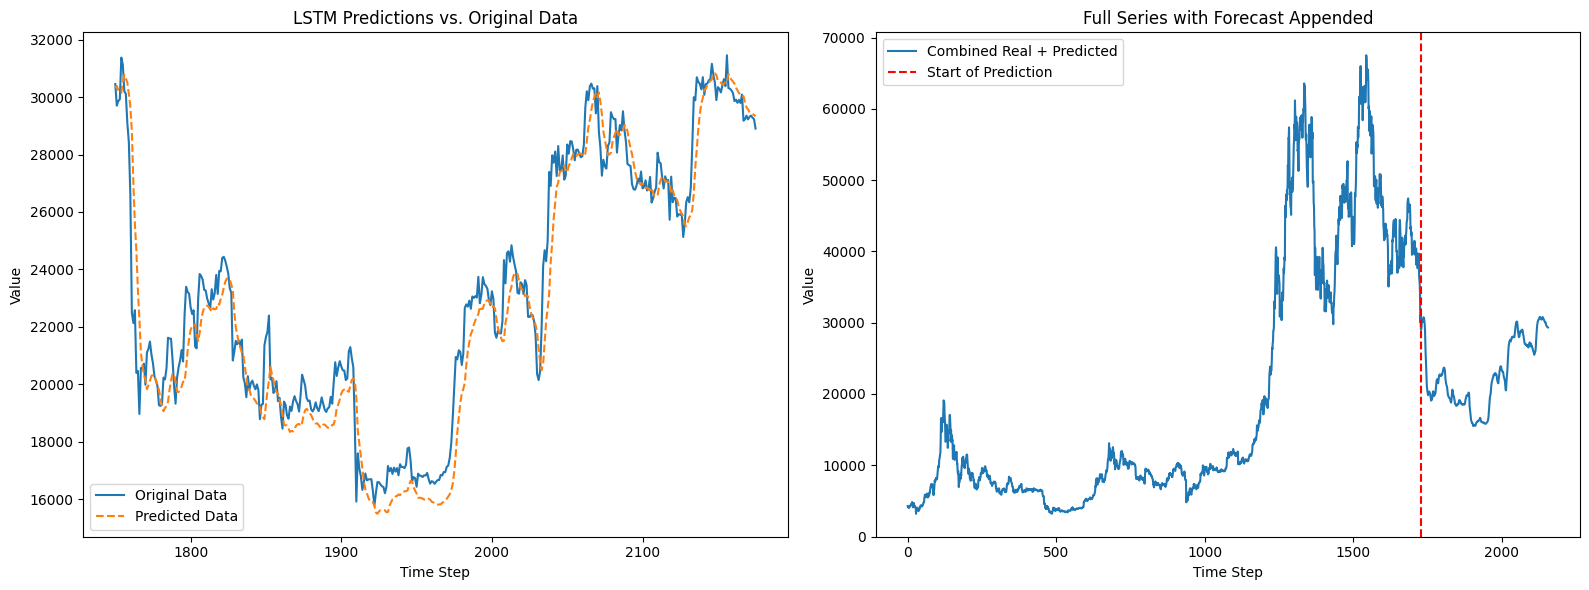

NMSE:   0.0687
R²:    0.9313
POCID: 47.53%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

### Previsão Multi-Step

In [ ]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

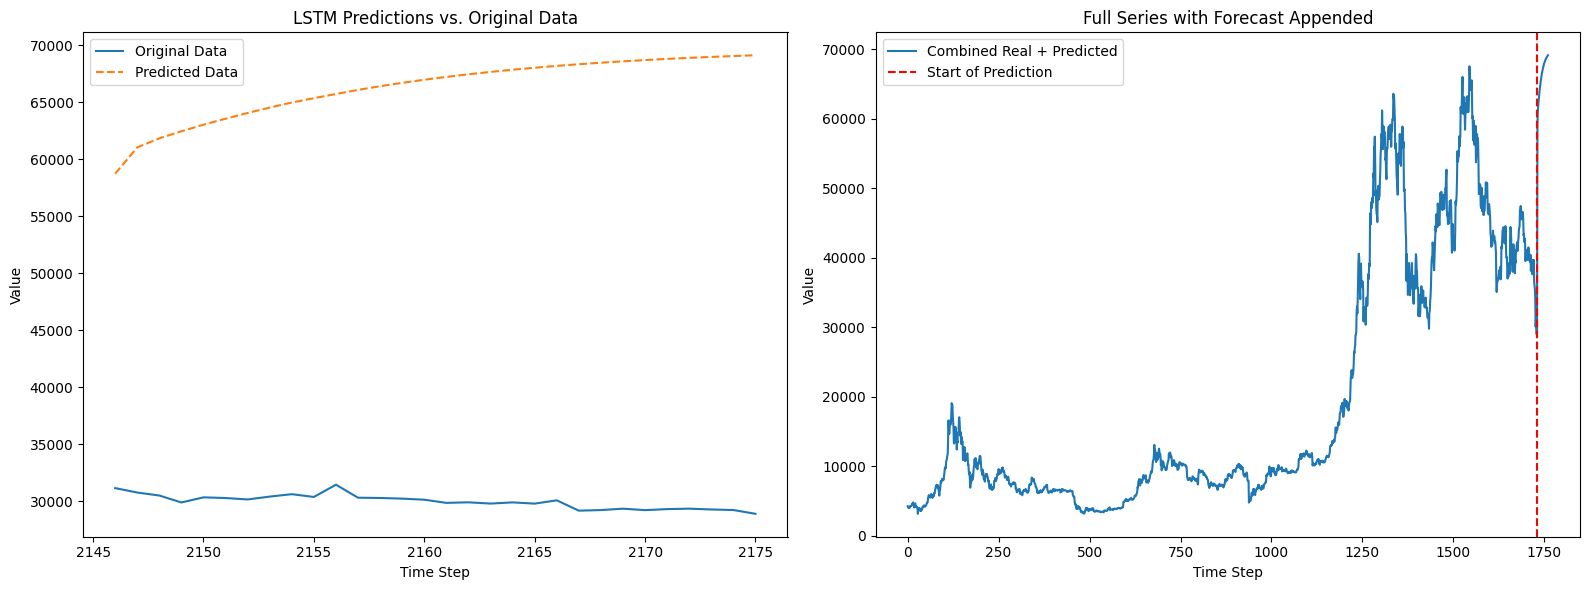

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       68967.5856973 , 69043.44550694, 69112.37297679])

In [ ]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Janela=50, Clip-margin=0.5, hidden_dim=200

In [ ]:
# Hiperparâmetros
seq_length = 50
num_epochs = 1000
hidden_dim = 200
layer_dim = 1
learning_rate = 0.01
patience = 20
clip_margin = 0.5

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1473, 50, 1])
torch.Size([167, 50, 1])
torch.Size([386, 50, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm_clip_margin(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Grad norm before clip: 0.3527
Grad norm after clip: 0.3527
Época 1/1000 — Train Loss: 0.0877 — Val Loss: 0.0221 — Streak: 0/20
Grad norm before clip: 0.7163
Grad norm after clip: 0.5000
Grad norm before clip: 0.1741
Grad norm after clip: 0.1741
Grad norm before clip: 0.2380
Grad norm after clip: 0.2380
Grad norm before clip: 0.2025
Grad norm after clip: 0.2025
Grad norm before clip: 0.1142
Grad norm after clip: 0.1142
Grad norm before clip: 0.1967
Grad norm after clip: 0.1967
Grad norm before clip: 1.1311
Grad norm after clip: 0.5000
Grad norm before clip: 0.1275
Grad norm after clip: 0.1275
Grad norm before clip: 0.2195
Grad norm after clip: 0.2195
Época 10/1000 — Train Loss: 0.0411 — Val Loss: 0.1611 — Streak: 9/20
Grad norm before clip: 0.2427
Grad norm after clip: 0.2427
Grad norm before clip: 0.2169
Grad norm after clip: 0.2169
Grad norm before clip: 0.1522
Grad norm after clip: 0.1522
Grad norm before clip: 0.0736
Grad norm after clip: 0.0736
Grad norm before clip: 0.2903
Grad no

LSTMModel(
  (lstm): LSTM(1, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

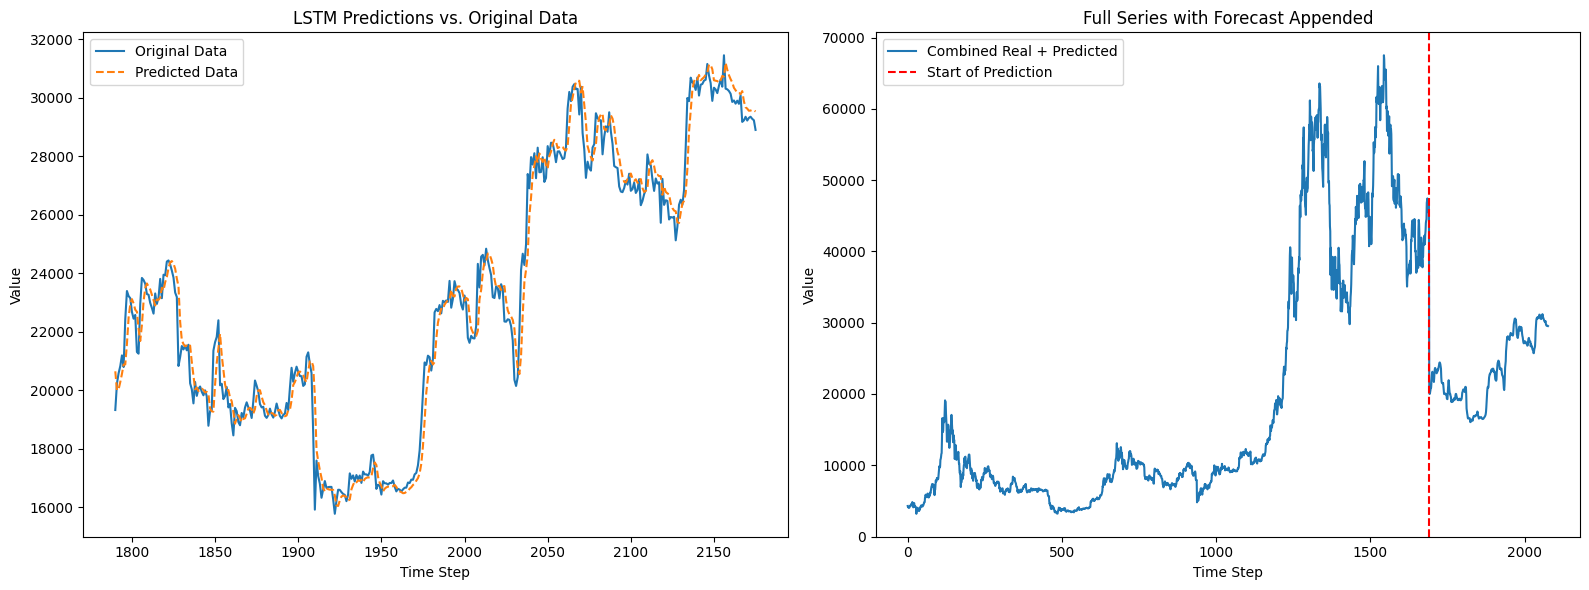

NMSE:   0.0262
R²:    0.9738
POCID: 44.42%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

### Previsão Multi-Step

In [ ]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

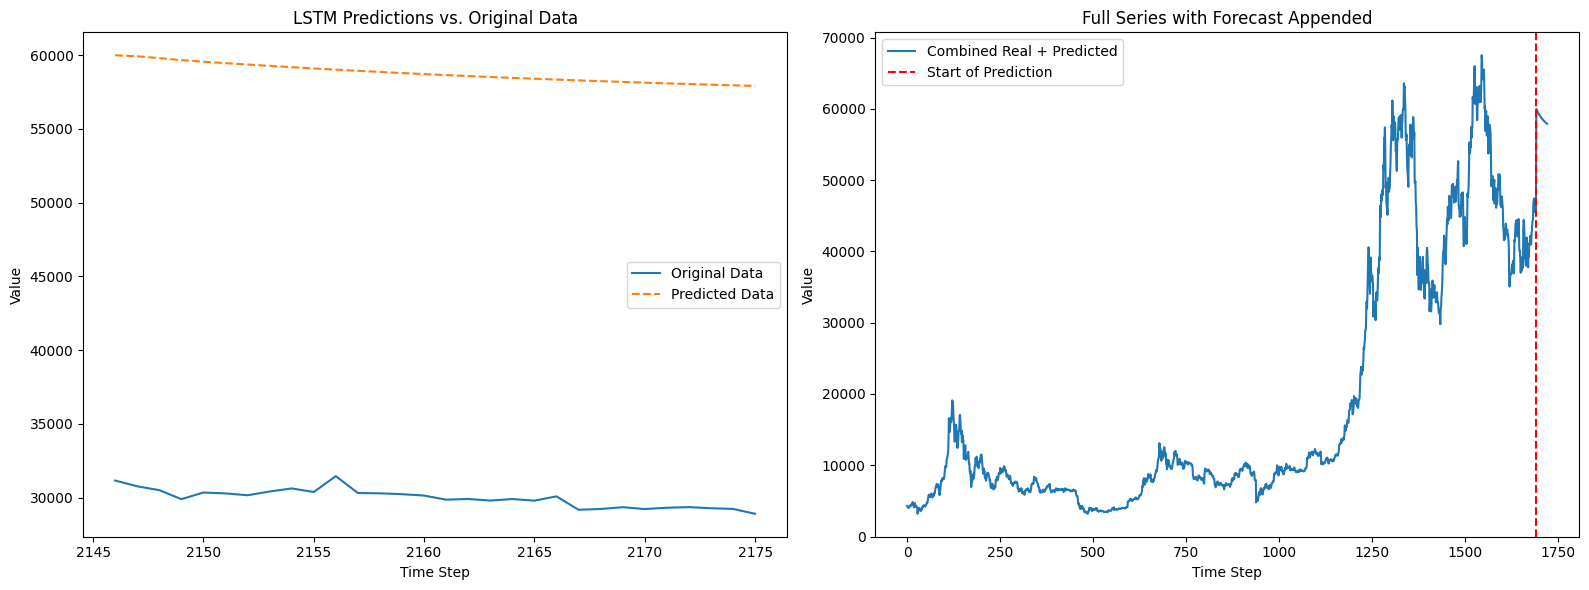

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       57995.50948329, 57952.77805133, 57911.5151524 ])

In [ ]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Optuna

In [ ]:
!pip install optuna
import optuna

def objective(trial):
    # 1) Sugestões de hiper-parâmetros
    seq_length  = trial.suggest_int("seq_length", 5, 50)
    hidden_dim  = trial.suggest_int("hidden_dim", 50, 200, step=25)
    layer_dim   = trial.suggest_int("layer_dim", 1, 5)
    learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    # 2) Prepara sequências com seq_length
    trainX, trainY = create_sequences(X_close_train, seq_length)
    valX,   valY   = create_sequences(X_close_val,   seq_length)

    # 3) Modelo, optimizer, critério
    model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 4) Treina e retorna val_loss
    _, val_loss = train_lstm(model, criterion, optimizer, trainX, trainY,
                             valX, valY, num_epochs=100, patience=10)
    return val_loss

# Cria estudo e roda
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best val loss:", study.best_value)


Best params: {'seq_length': 5, 'hidden_dim': 100, 'layer_dim': 2, 'lr': 0.004239530663899114}
Best val loss: 0.001442335662432015

In [ ]:
# Hiperparâmetros
seq_length = 5
num_epochs = 1000
hidden_dim = 100
layer_dim = 2
learning_rate = 0.0042
patience = 20

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1518, 5, 1])
torch.Size([212, 5, 1])
torch.Size([431, 5, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1402 — Val Loss: 0.4338 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0417 — Val Loss: 0.1364 — Streak: 6/20
Época 20/1000 — Train Loss: 0.0105 — Val Loss: 0.0301 — Streak: 5/20
Época 30/1000 — Train Loss: 0.0039 — Val Loss: 0.0026 — Streak: 2/20
Época 40/1000 — Train Loss: 0.0019 — Val Loss: 0.0028 — Streak: 12/20
--> Early stopping na época 48. Melhor Val Loss: 0.0014


(LSTMModel(
   (lstm): LSTM(1, 100, num_layers=2, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0014, device='cuda:0'))

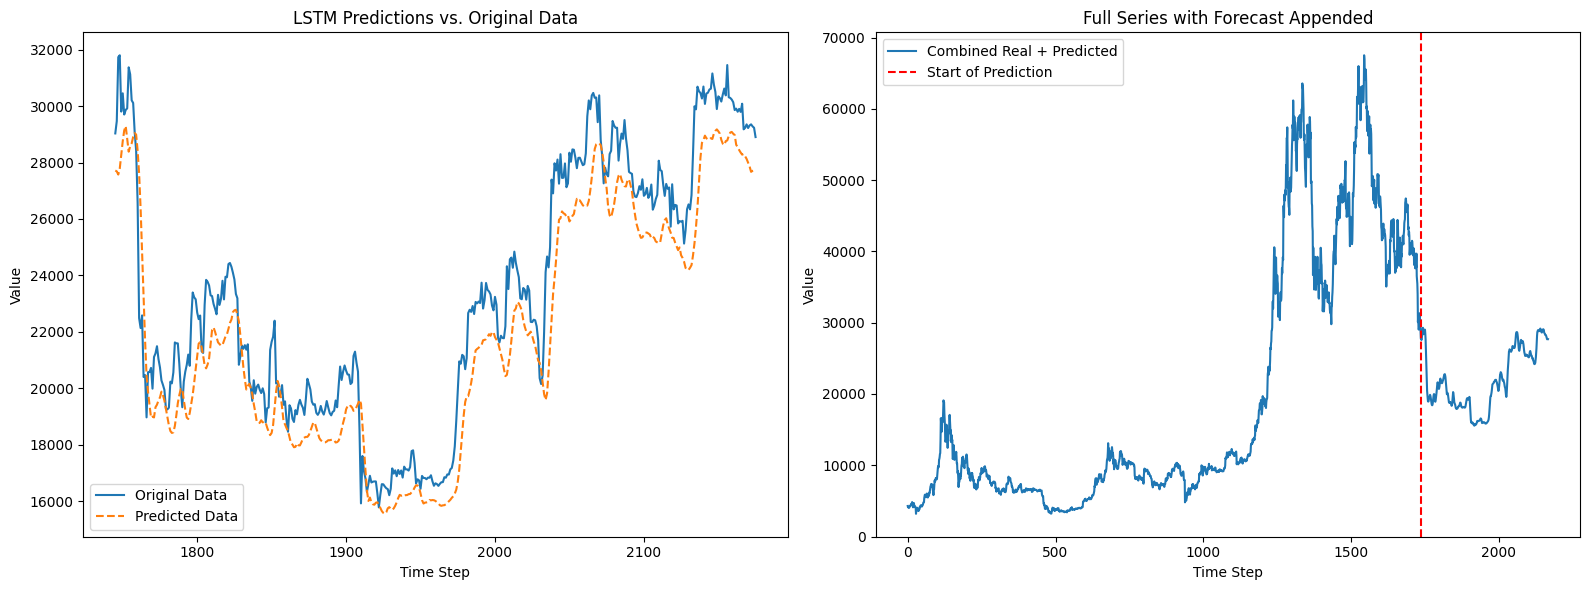

NMSE:   0.1480
R²:    0.8520
POCID: 44.88%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

## Experimento - Mudança na patience (aumento em 50%)


In [ ]:
# Hiperparâmetros
seq_length = 50
num_epochs = 1000
hidden_dim = 200
layer_dim = 1
learning_rate = 0.01
patience = 30
clip_margin = 0.2

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1473, 50, 1])
torch.Size([167, 50, 1])
torch.Size([386, 50, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm_clip_margin(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Grad norm before clip: 0.3007
Grad norm after clip: 0.3007
Época 1/1000 — Train Loss: 0.0803 — Val Loss: 0.0056 — Streak: 0/30
Grad norm before clip: 1.3546
Grad norm after clip: 1.3546
Grad norm before clip: 0.0974
Grad norm after clip: 0.0974
Grad norm before clip: 0.2281
Grad norm after clip: 0.2281
Grad norm before clip: 0.2551
Grad norm after clip: 0.2551
Grad norm before clip: 0.2321
Grad norm after clip: 0.2321
Grad norm before clip: 0.1703
Grad norm after clip: 0.1703
Grad norm before clip: 0.0722
Grad norm after clip: 0.0722
Grad norm before clip: 1.4913
Grad norm after clip: 1.4913
Grad norm before clip: 0.0918
Grad norm after clip: 0.0918
Época 10/1000 — Train Loss: 0.0415 — Val Loss: 0.1848 — Streak: 9/30
Grad norm before clip: 0.1729
Grad norm after clip: 0.1729
Grad norm before clip: 0.2057
Grad norm after clip: 0.2057
Grad norm before clip: 0.2253
Grad norm after clip: 0.2253
Grad norm before clip: 0.2476
Grad norm after clip: 0.2476
Grad norm before clip: 0.2468
Grad no

LSTMModel(
  (lstm): LSTM(1, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

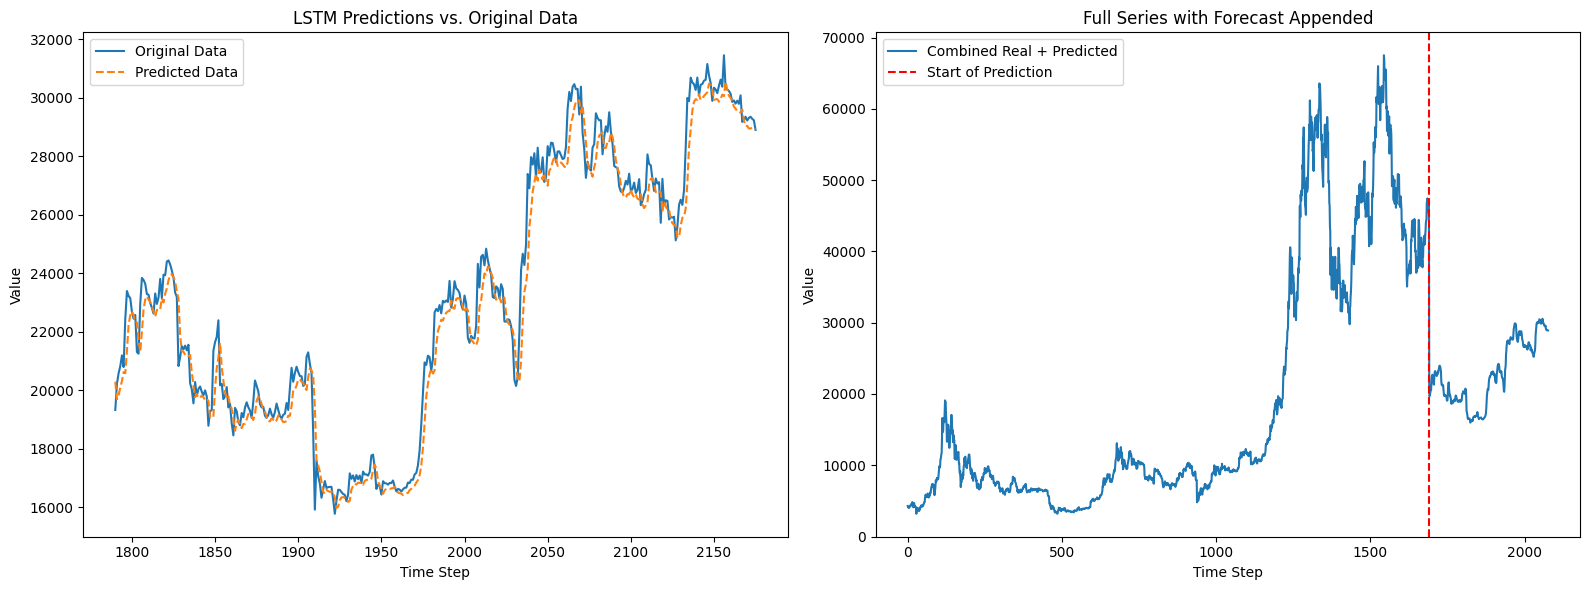

NMSE:   0.0293
R²:    0.9707
POCID: 45.45%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

### Multi-Step

In [ ]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

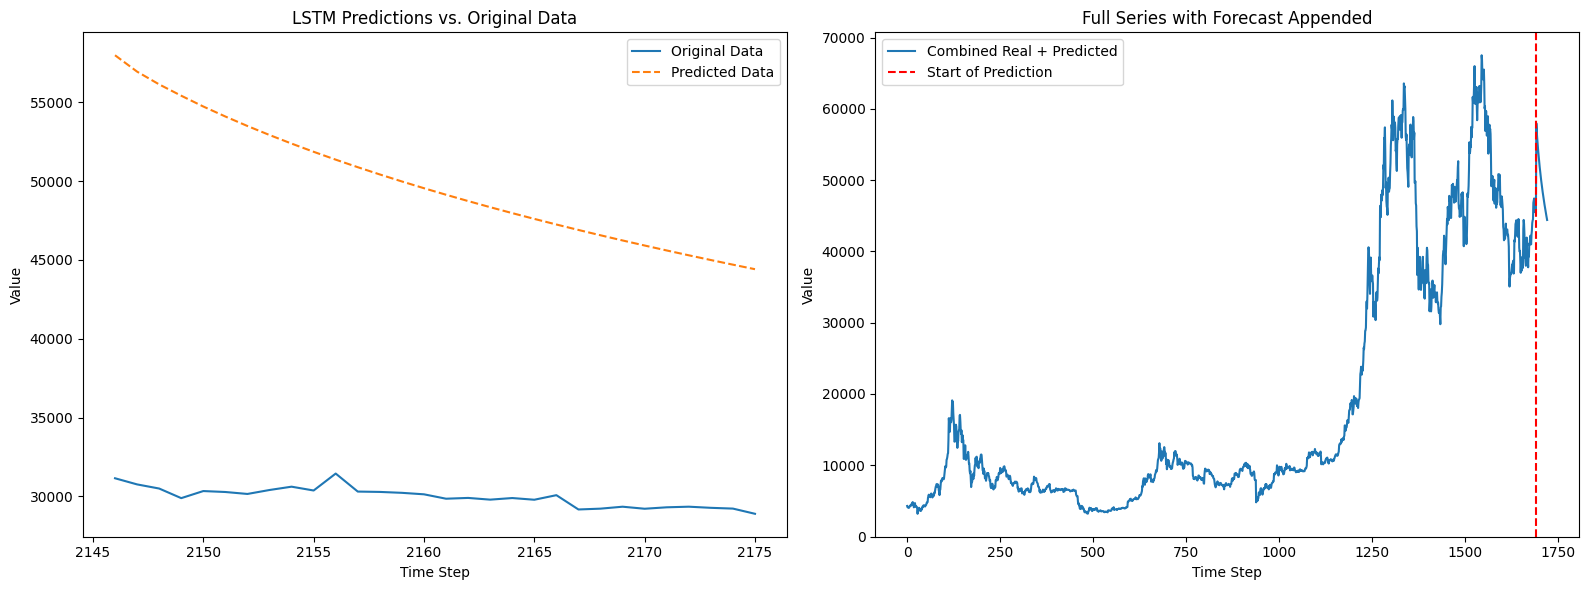

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       44996.43655188, 44702.67235453, 44414.80028606])

In [ ]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Mudança na patience (reducao em 10%)


In [ ]:
# Hiperparâmetros
seq_length = 50
num_epochs = 1000
hidden_dim = 200
layer_dim = 1
learning_rate = 0.01
patience = 10
clip_margin = 0.2

In [ ]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1473, 50, 1])
torch.Size([167, 50, 1])
torch.Size([386, 50, 1])


In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_lstm_clip_margin(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Grad norm before clip: 0.5644
Grad norm after clip: 0.5644
Época 1/1000 — Train Loss: 0.1237 — Val Loss: 0.0809 — Streak: 0/20
Grad norm before clip: 0.3248
Grad norm after clip: 0.3248
Grad norm before clip: 0.2014
Grad norm after clip: 0.2014
Grad norm before clip: 0.2029
Grad norm after clip: 0.2029
Grad norm before clip: 0.1044
Grad norm after clip: 0.1044
Grad norm before clip: 0.3520
Grad norm after clip: 0.3520
Grad norm before clip: 0.2241
Grad norm after clip: 0.2241
Grad norm before clip: 0.2705
Grad norm after clip: 0.2705
Grad norm before clip: 3.9487
Grad norm after clip: 3.9487
Grad norm before clip: 0.4639
Grad norm after clip: 0.4639
Época 10/1000 — Train Loss: 0.0676 — Val Loss: 0.3040 — Streak: 4/20
Grad norm before clip: 0.4692
Grad norm after clip: 0.4692
Grad norm before clip: 0.4326
Grad norm after clip: 0.4326
Grad norm before clip: 0.3745
Grad norm after clip: 0.3745
Grad norm before clip: 0.3004
Grad norm after clip: 0.3004
Grad norm before clip: 0.2056
Grad no

LSTMModel(
  (lstm): LSTM(1, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

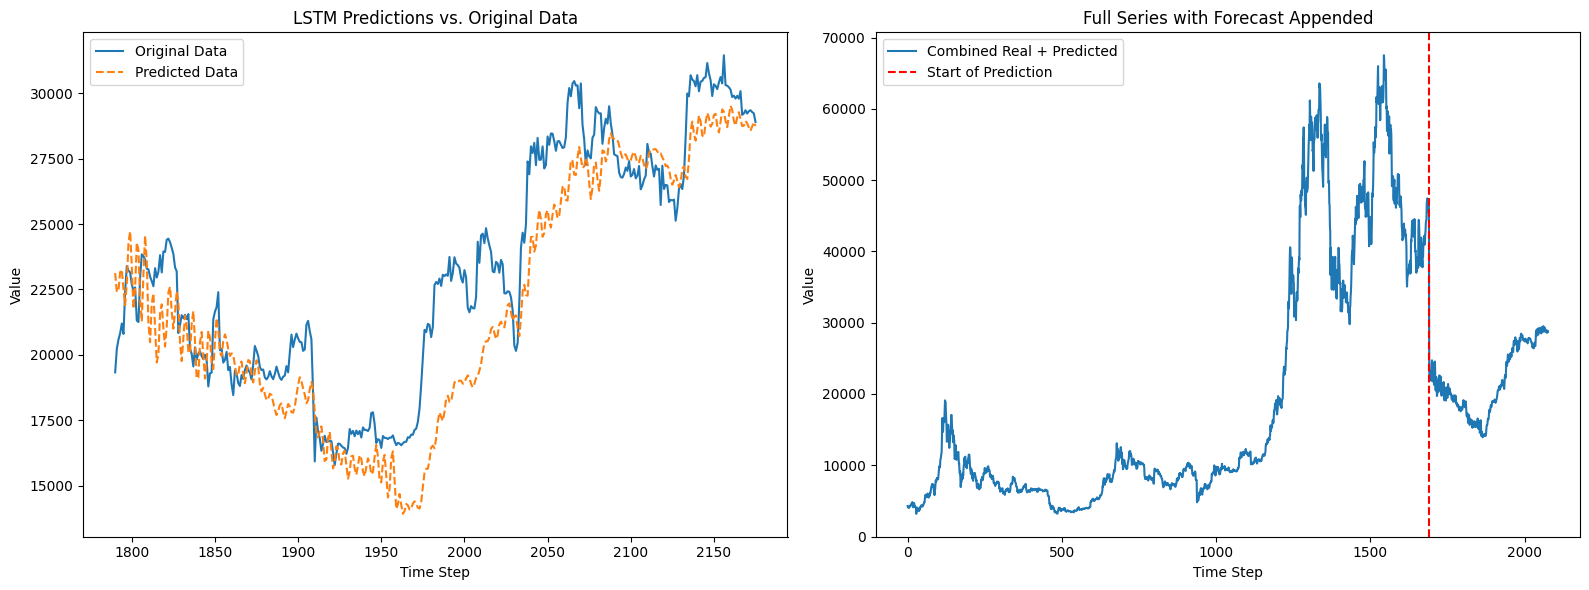

NMSE:   0.2406
R²:    0.7594
POCID: 48.57%


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5, col_idx=3)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

y_true = np.asarray(df_close.values[-len(y_pred_denorm):]).flatten()
y_pred = np.asarray(y_pred_denorm).flatten()

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
nmse = mse / np.var(y_true)

print(f"NMSE:   {nmse:.4f}")
print(f"R²:    {r2:.4f}")

# POCID: Percentual de acerto direcional
# 1) calcula as diferenças
diff_true = np.diff(y_true)
diff_pred = np.diff(y_pred)
# 2) sinais
dir_true = np.sign(diff_true)
dir_pred = np.sign(diff_pred)
# 3) alinha comprimentos
min_len = min(len(dir_true), len(dir_pred))
dir_true = dir_true[:min_len]
dir_pred = dir_pred[:min_len]
# 4) compara
pocid = np.mean(dir_true == dir_pred) * 100
print(f"POCID: {pocid:.2f}%")

### Multi-Step

In [ ]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

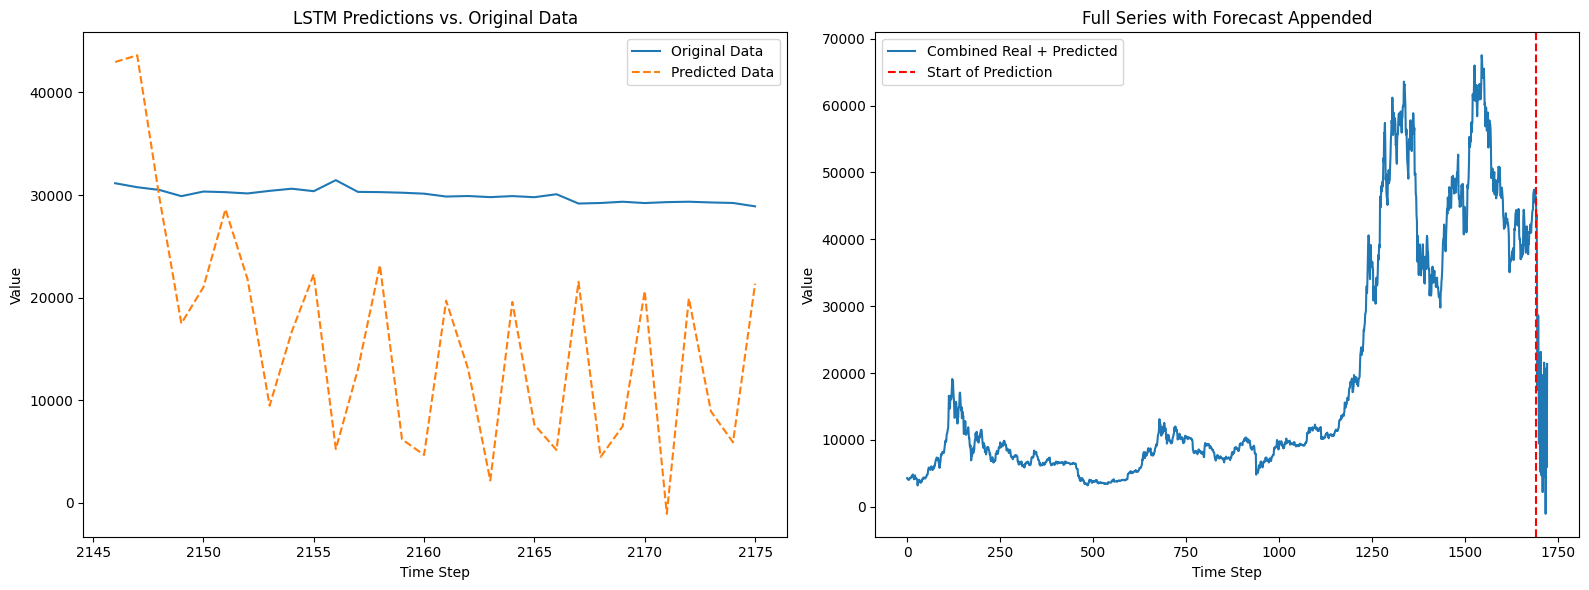

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
        8924.22062878,  5910.7251445 , 21366.16703881])

In [ ]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)